# ECE 447: Control of Magnetic Levitation Device

Eric Klavins

Copyright &copy; University of Washington, 2019

# Code

In [1]:
import numpy as np
import scipy.integrate as spi
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sympy import *
from matplotlib import animation
from JSAnimation.IPython_display import display_animation
from control import * 

%matplotlib inline

# Comment out in Google colab 
init_printing(use_latex='mathjax')

# Uncomment in below Google colab to render sympy equations nicely
# def custom_latex_printer(exp,**options):
#     from google.colab.output._publish import javascript
#     url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=default"
#     javascript(url=url)
#     return printing.latex(exp,**options)

# The System

A steel ball with mass $M$ is levitated under an electromagnet. In the input $u$ to the system is the voltage applied to the electromagnet. The output is the position of the ball and is measured with a photo-detector. The system is illustrated below.

<img width=40% src="https://raw.githubusercontent.com/klavins/ECE447/master/images/levitation-up.png">

The equations define the rates of change for the ball's position $x$, velocity $v$, and the magnet's inductance $I$. For convenience, the positive direction for $x$ is down. 

<table width=100% style="background: white">

<tr></tr>

<tr><td>

\begin{align}
\dot x & = v \\
\dot v & = \frac{C}{M}\left(\frac{I}{x}\right)^2 - g \\
\dot I & = \frac{1}{L} \left ( -RI + 2 C \frac{Iv}{x^2} + u \right )
\end{align}

</td><td>

  <table>
    <tr><td style="text-align: left">C</td>
        <td style="text-align: left">Magnet constant</td>
        <td style="text-align: left">$10^{-4}$</td></tr>
    <tr><td style="text-align: left">g</td>
        <td style="text-align: left">Gravity</td>
        <td style="text-align: left">9.81</td></tr>
    <tr><td style="text-align: left">L</td>
        <td style="text-align: left">Inductance</td>
        <td style="text-align: left">1.0</td></tr>
    <tr><td style="text-align: left">R</td>
        <td style="text-align: left">Resistance</td>
        <td style="text-align: left">30.0</td></tr>
    <tr><td style="text-align: left">M</td>
        <td style="text-align: left">Mass</td>
        <td style="text-align: left">12 &times; $10^{-3}$</td></tr>
    <tr><td style="text-align: left">u</td>
        <td style="text-align: left">Input voltage</td>
        <td style="text-align: left"></td></tr>    
  </table>

</td></tr></table>

Control Goal
---

The goal is to control the ball so that it stays 0.5 cm below the magnet. That is,

$$
x^* = \frac{1}{2}\; \mathrm{cm} = \frac{1}{200} \; \mathrm{m}.
$$

This requires a constant voltage, which can be determined by noting that when we have achieved the goal state, the rates of change for the equations of motion should be zero. Using the second equation, we get

$$
\dot v = 0 = \frac{C}{M}\left(\frac{I}{x^*}\right)^2 + g
$$

which implies that

$$
I^* = x^* \sqrt{\frac{Mg}{C}} .
$$

Also, 

$$
\dot I = 0 = \frac{1}{L} \left ( -RI + u \right )
$$

since $\dot x = v = 0$. Solving for $u$ gives

$$
u^* = R I^* = \frac{R}{200}\frac{Mg}{C} .
$$

Performance and Safety
---

**Steady state error:** Note that this system is regulating the ball around a given operating point. We don't expect the user to change that operating point, so we do not need to change the system's type (number of poles at zero).

**Overshoot:** We should understand what happens with an initial positional or velocity error, which could push the ball away from the operating point and possibly make it hit the magnet 5 cm away. For now, let's say that we want close to 0% overshoot.

**Sensitivity:** All of parameters are estimates. The most important metric is probably something like a 10% change in any parameter should not produced more than a 10% change in the percent overshoot response to an impulse disturbance.

**Nonlinear Model:** We are designing a linear controller for a nonlinear model. We should evaluate how well it works not just with linear simulations, but also in the context of the full nonlinear system.

# Modeling

In this section we will:

- Encode the model in `sympy`
- Change to error coordinates, so the equilibrium of the system is at $(0,0,0)$.
- Linearize the system

In [338]:
# Model
var("x v i C g L R M u")

params = [
    (R,30.0),
    (L,1.0),
    (C,0.0004),
    (g,9.81),
    (M,0.0012)
]

dotx = v
dotv = (C/M)*(i/x)**2 - g
doti = (1/L)*(-R*i + 2*C*i*v/(x**2) + u)

dotx, dotv, doti

⎛             2⋅C⋅i⋅v          ⎞
⎜             ─────── - R⋅i + u⎟
⎜      2          2            ⎟
⎜   C⋅i          x             ⎟
⎜v, ──── - g, ─────────────────⎟
⎜      2              L        ⎟
⎝   M⋅x                        ⎠

In [339]:
# open loop voltage needed to achieve an x = 5 cm setpoint 
xdes = 5/100
sol = solve([dotx, dotv.subs(x,xdes), doti.subs(x,xdes)], u,i,v)
udes = sol[1][0]
ides = sol[1][1]
udes, ides

⎛           _____           _____⎞
⎜          ╱ M⋅g           ╱ M⋅g ⎟
⎜0.05⋅R⋅  ╱  ─── , 0.05⋅  ╱  ─── ⎟
⎝       ╲╱    C         ╲╱    C  ⎠

In [340]:
# Model in error coordinates
var("xe, ve, ie, ue")

coordsub = [
    (x,xe+xdes),
    (v,ve+0),
    (i,ie+ides),
    (u,ue+udes)
]

dotxe = ve
dotve = dotv.subs(coordsub)
dotie = doti.subs(coordsub)

dotxe, dotve, dotie

⎛                                         ⎛              _____⎞               
⎜                                         ⎜             ╱ M⋅g ⎟               
⎜                           2      2⋅C⋅ve⋅⎜ie + 0.05⋅  ╱  ─── ⎟              _
⎜      ⎛              _____⎞              ⎝          ╲╱    C  ⎠             ╱ 
⎜      ⎜             ╱ M⋅g ⎟       ──────────────────────────── + 0.05⋅R⋅  ╱  
⎜    C⋅⎜ie + 0.05⋅  ╱  ─── ⎟                          2                  ╲╱   
⎜      ⎝          ╲╱    C  ⎠               (xe + 0.05)                        
⎜ve, ──────────────────────── - g, ───────────────────────────────────────────
⎜                      2                                                 L    
⎝         M⋅(xe + 0.05)                                                       

                                   ⎞
                                   ⎟
____     ⎛              _____⎞     ⎟
M⋅g      ⎜             ╱ M⋅g ⎟     ⎟
───  - R⋅⎜ie + 0.05⋅  ╱  ─── ⎟ + ue⎟
 C       ⎝          ╲╱  

In [341]:
# Linearization

steady_state = [ (xe,0), (ve,0), (ie,0)]
f = Matrix([dotxe, dotve, dotie])

A = f.jacobian([xe, ve, ie]).subs(steady_state)
B = f.jacobian([ue]).subs(steady_state)
Cc = Matrix([[1,0,0]])
A,B,Cc

⎛⎡   0            1                 0        ⎤, ⎡0⎤, [1  0  0]⎞
⎜⎢                                           ⎥  ⎢ ⎥           ⎟
⎜⎢                                      _____⎥  ⎢0⎥           ⎟
⎜⎢                                     ╱ M⋅g ⎥  ⎢ ⎥           ⎟
⎜⎢                           40.0⋅C⋅  ╱  ─── ⎥  ⎢1⎥           ⎟
⎜⎢                                  ╲╱    C  ⎥  ⎢─⎥           ⎟
⎜⎢-40.0⋅g         0          ────────────────⎥  ⎣L⎦           ⎟
⎜⎢                                  M        ⎥                ⎟
⎜⎢                                           ⎥                ⎟
⎜⎢                    _____                  ⎥                ⎟
⎜⎢                   ╱ M⋅g                   ⎥                ⎟
⎜⎢         40.0⋅C⋅  ╱  ───                   ⎥                ⎟
⎜⎢                ╲╱    C          -R        ⎥                ⎟
⎜⎢   0     ────────────────        ───       ⎥                ⎟
⎝⎣                L                 L        ⎦                ⎠

# Model comparisons



To compare the nonlinear and linear models, we need to look at all three equations with respect to all three variables as well as the control input. Note, however, that all three variables and the control input show up linearly in the nonlinear model, except for

- $x_e$ in the equation for $\dot v_e$
- $i_e$ in the equation for $\dot v_e$
- $x_e$ in the equation for $\dot i_e$

In this last occurrence, $x_e$ shows up in the denominator, but in the numerator $v_e = 0$ makes the nonlinear model zero. So just looking at the first two occurrences is informative.

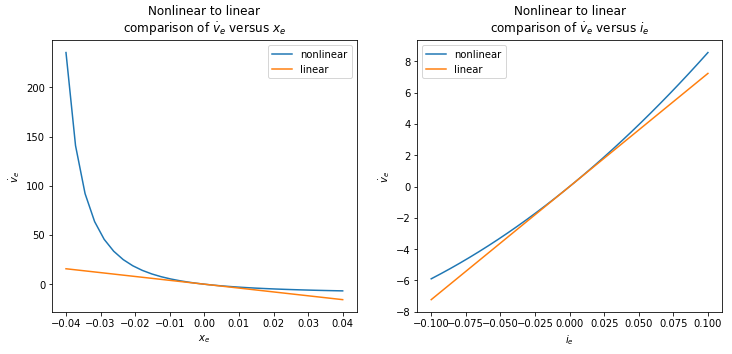

In [342]:
# Comparison between Nonlinear and linear models

lin = A.subs(params)*Matrix([[xe],[ve],[ie]])+B.subs(params)*ue    

fve = lambdify([xe,ve,ie,ue],dotve.subs(params),'numpy')
gve = lambdify([xe,ve,ie,ue],lin[1,0].subs(params),'numpy')

xevals = np.linspace(-0.04,0.04,30)
ievals = np.linspace(-0.1,0.1,30)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

a0 = ax[0].plot(xevals,fve(xevals,0,0,0),xevals,gve(xevals,0,0,0));
a1= ax[1].plot(ievals,fve(0,0,ievals,0),ievals,gve(0,0,ievals,0));

ax[0].legend(a0, [ "nonlinear", "linear" ])
ax[0].set_title("Nonlinear to linear\ncomparison of $\dot v_e$ versus $x_e$")
ax[0].set_xlabel("$x_e$")
ax[0].set_ylabel("$\dot v_e$")

ax[1].legend(a0, [ "nonlinear", "linear" ])
ax[1].set_title("Nonlinear to linear\ncomparison of $\dot v_e$ versus $i_e$")
ax[1].set_xlabel("$i_e$")
ax[1].set_ylabel("$\dot v_e$")

fig.subplots_adjust(hspace=0.2)

# Stability

In [343]:
# Put in parameters and find eigenvalues. Note the system
# is unstable, which makes sense. Any deviation from the steady
# state is either going to drop the marble, or make it stick
# to the magnet.

An = A.subs(params)
eigs = An.eigenvals()
[N(ev) for ev in eigs]

[-30.1454601209201, 0.0727300604600666 - 19.7611050453331⋅ⅈ, 0.072730060460066
6 + 19.7611050453331⋅ⅈ]

In [344]:
# Find the transfer function symbolically
var("s")
Gsym = (Cc*(s*eye(3)-A).inv()*B)[0,0]
Gsym = Gsym.simplify()
Gsym

                               _____                   
                              ╱ M⋅g                    
                    40.0⋅C⋅  ╱  ───                    
                           ╲╱    C                     
───────────────────────────────────────────────────────
  ⎛                    ⎛          2⎞     ⎛          2⎞⎞
M⋅⎝-1600.0⋅C⋅g⋅s + L⋅s⋅⎝40.0⋅g + s ⎠ + R⋅⎝40.0⋅g + s ⎠⎠

In [345]:
# Substitute in the parameters
Gsubs = Gsym.subs(params).cancel()
Gsubs

            72.3325652801005           
───────────────────────────────────────
     3         2                       
1.0⋅s  + 30.0⋅s  + 386.1216⋅s + 11772.0

In [346]:
# Convert to a control systems toolbox represetation

num,den = fraction(Gsubs)
a = [float(c) for c in Poly(num,s).coeffs()]
b = [float(c) for c in Poly(den,s).coeffs()]
G = tf(a,b)
G


              72.33
----------------------------------
s^3 + 30 s^2 + 386.1 s + 1.177e+04

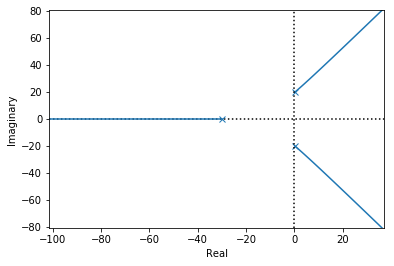

In [347]:
# Plot the root locus. This shows the a simple proportional gain
# will not work
r,k=root_locus(G)

# Control Design

We need to place a zero somewhere that stabilizes the system
(pulling the two zeros at infinity to the left) and that allows
us to get a range of performances. 

Recall that to effect percent overshoot, we need to be able to damp the closed loop system so that the poles have small imaginary parts.

<img src="https://raw.githubusercontent.com/klavins/ECE447/master/images/performance-summary.png" width=50%>

One way to do this is to choose two zeros such that if they were the poles, they would give the desired performance.

In [326]:
# Choose two zeros 
((s+5)*(s+20)).expand()

 2             
s  + 25⋅s + 100

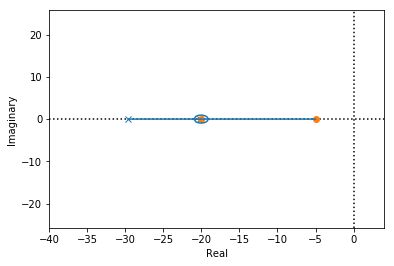

In [327]:
Gc = tf([1,25,100],[1])
r,k=root_locus(series(Gc,G),xlim=(-40,4))

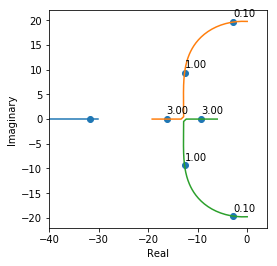

In [14]:
# Plot
def get_poles(klist,Gc,G):
    return np.array([pole(feedback(series(tf([k],[1]),Gc,G))) for k in klist])

# Define all the values of K we will use for the plot
Kvals = np.linspace(0.001,10,500)

# Some sample gains
gains = np.array([ 0.1, 1, 3 ])

plt.plot(
    np.real(get_poles(Kvals,Gc,G)),
    np.imag(get_poles(Kvals,Gc,G)),
)

plt.xlabel("Real")
plt.ylabel("Imaginary")

for k,p in zip(gains,get_poles(gains,Gc,G)):
#     plt.text(np.real(p[0]), np.imag(p[0])+5,"%0.2f" % k)    
    plt.text(np.real(p[1]), np.imag(p[1])+1,"%0.2f" % k)   
    plt.text(np.real(p[2]), np.imag(p[2])+1,"%0.2f" % k)       

plt.scatter(np.real(get_poles(gains,Gc,G)),np.imag(get_poles(gains,Gc,G)))

plt.xlim(-40,4);
plt.ylim(-22,22);
plt.gca().set_aspect(1)
plt.show()

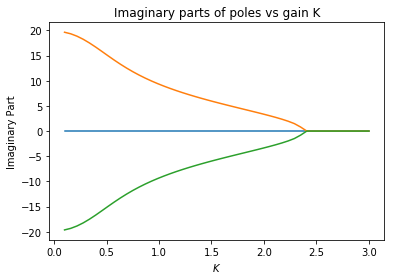

In [15]:
ks = np.linspace(0.1,3,50) 
poles = get_poles(ks,Gc,G);

plt.plot(ks,np.imag(poles));
plt.xlabel("$K$")
plt.ylabel("Imaginary Part")
plt.title("Imaginary parts of poles vs gain K");

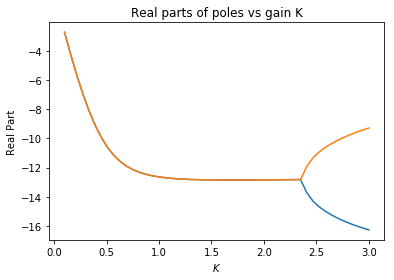

In [16]:
plt.plot(ks,np.real(poles)[:,1]);
plt.plot(ks,np.real(poles)[:,2]);
plt.xlabel("$K$")
plt.ylabel("Real Part")
plt.title("Real parts of poles vs gain K");

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


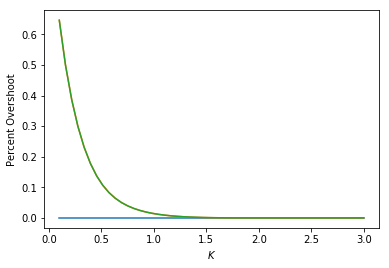

In [109]:
# Plot overshoot versus K

# e^{-z pi/b} = e^{-wz pi / wb}
# wz + wb i = pole
# wz = re(pole)
# wb = im(pole)
# po = e^{wz * pi / wb}

ks = np.linspace(0.1,3,50) 
poles = get_poles(ks,Gc,G);
overshoot = np.exp(np.real(poles)*np.pi / np.abs(np.imag(poles)))
plt.plot(ks,overshoot)
plt.xlabel("$K$")
plt.ylabel("Percent Overshoot");

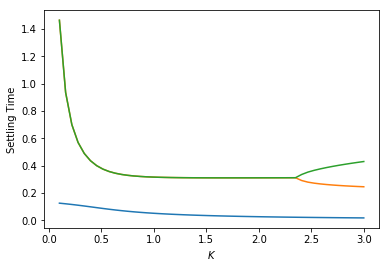

In [110]:
# Time constant
# 1 / zw  = 1 / re(pole)

Ts = -4/np.real(poles)
plt.plot(ks,Ts)
plt.xlabel("$K$")
plt.ylabel("Settling Time");

In [188]:
# Gain choice
pole(feedback(series(tf([1],[1.75]),Gc,G)))

array([-48.98394149 +0.j        , -11.17447648+14.13630902j,
       -11.17447648-14.13630902j])

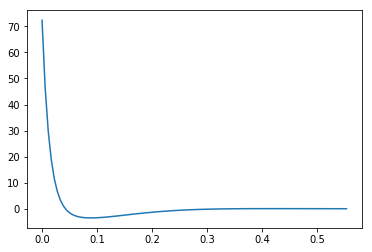

In [187]:
# Plot of linear response
t,y = impulse_response(feedback(series(tf([1],[1]),Gc,G)));
plt.plot(t,y);

# Sensitivity to Magnet Constant

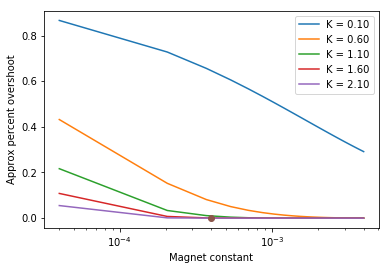

In [315]:
Cnom = 0.0004

def plot_sense(k,plt):

    Gcontrol = (s+5)*(s+20)
    T = k*Gcontrol*Gsym / ( 1 + k*Gcontrol*Gsym ).simplify()

    def po(c):
        TC = T.subs(C,c).subs(params).cancel()
        num,den = fraction(TC)
        poles = solve(den.subs(C,c),s)
        return exp(re(poles[1]) * pi / abs(im(poles[1])))

    cvals = np.linspace(0.1*Cnom, 10*Cnom, 25)
    tcvals = np.array([po(c) for c in cvals])

    plt.plot(cvals, tcvals, label="K = %0.2f" % k);
    
plt.plot()
[plot_sense(k,plt) for k in np.linspace(0.1,2.1,5)]
plt.plot([Cnom],[0],'o')
    
plt.xscale('log')
plt.xlabel("Magnet constant")
plt.ylabel("Approx percent overshoot");
plt.legend();


# Nonlinear Simulation

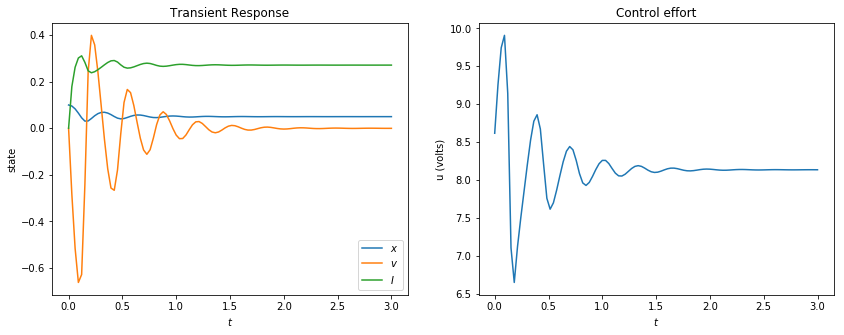

In [191]:
# Simulate the system
ldx = lambdify([x,v,i], dotx.subs(params))
ldv = lambdify([x,v,i], dotv.subs(params))
ldi = lambdify([x,v,i,u], doti.subs(params))

# Steay state values
xss = xdes
iss = ides.subs(params)

# Initial condition as though you trop the ball in from above
X0 = [xss+0.05,0,0]

# Feedforward Input
uff = udes.subs(params)

# Control law
def voltage(x,v,i):
    K = .1
    xe = xdes - x          # positional error
    ve = 0 - v             # velocity error
    ae = 0 - ldv(x,v,i)    # acceleration error
    return uff + K * ( ae + 25*ve + 100*xe )

# ODE right hand side
def f(X,t):
    x,v,i = X
    u = voltage(x,v,i)
    return [
        ldx(x,v,i),
        ldv(x,v,i),
        ldi(x,v,i,u),
    ]

# Simulate
tvals = np.linspace(0,3,100)
X = spi.odeint(f,X0,tvals)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plots = ax[0].plot(tvals,X);
ax[1].plot(tvals,voltage(X[:,0],X[:,1],X[:,2]));
fig.subplots_adjust(wspace=0.2)
ax[0].legend(plots, ["$x$", "$v$", "$I$"]);
ax[0].set_xlabel("$t$")
ax[0].set_ylabel("state")
ax[0].set_title("Transient Response");
ax[1].set_xlabel("$t$")
ax[1].set_ylabel("u (volts)")
ax[1].set_title("Control effort");

# Animation


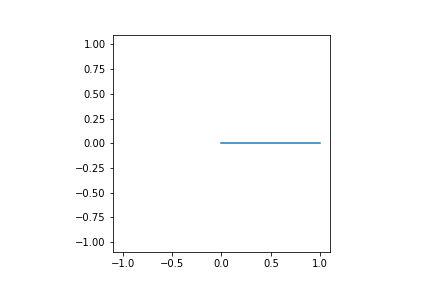
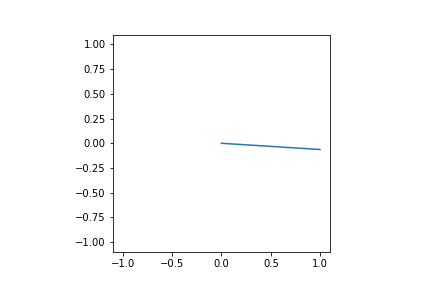
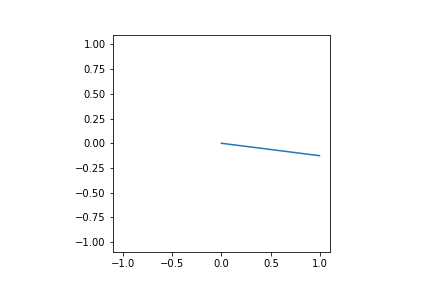
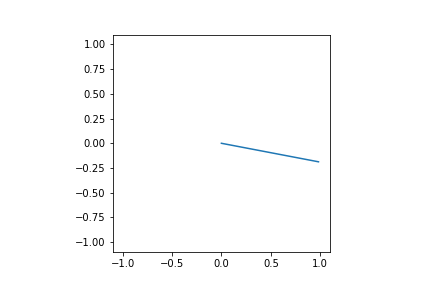
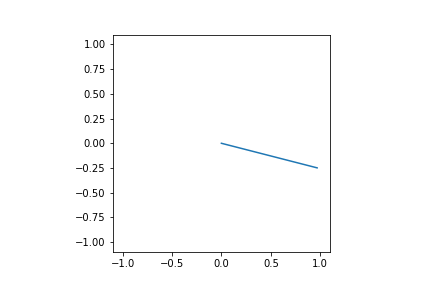
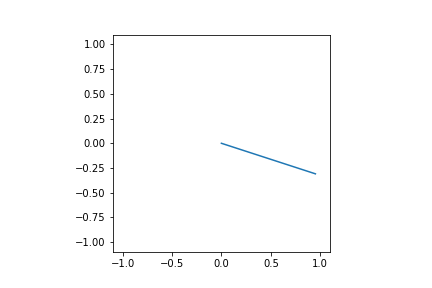
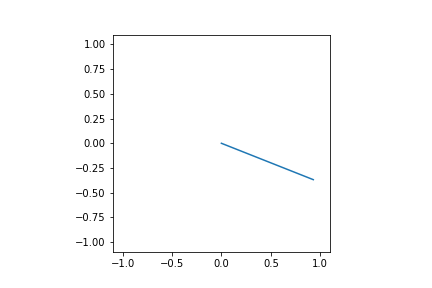
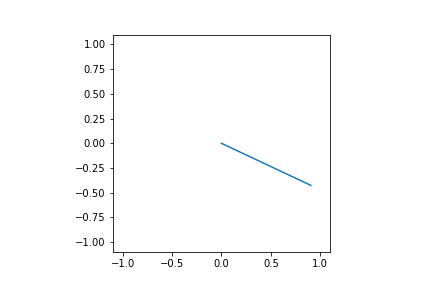
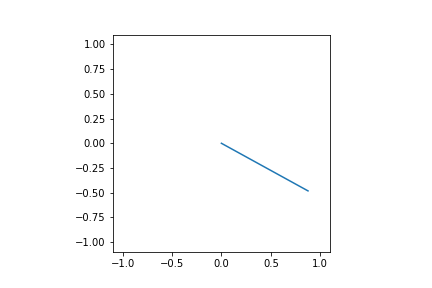
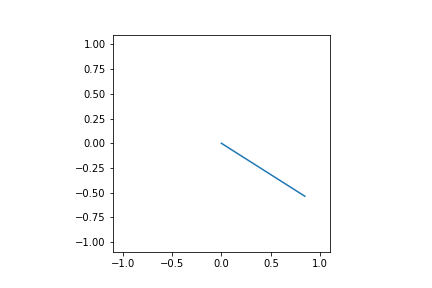
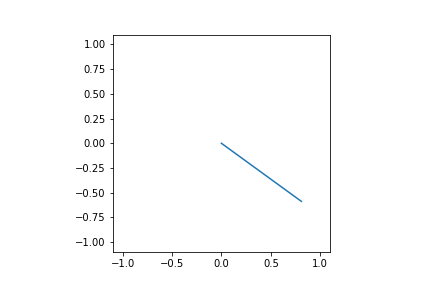
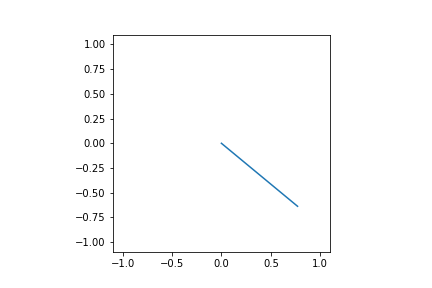
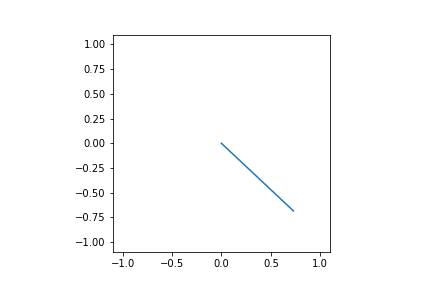
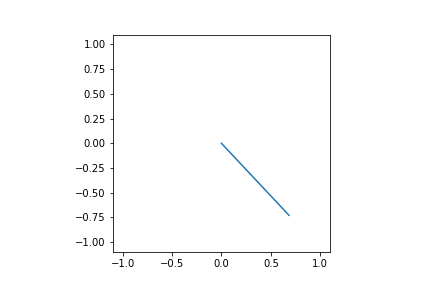
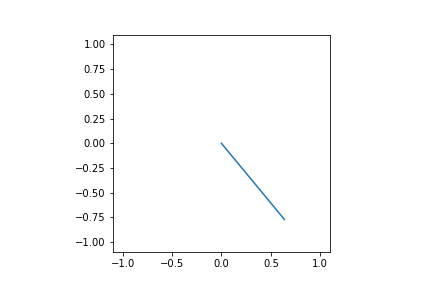
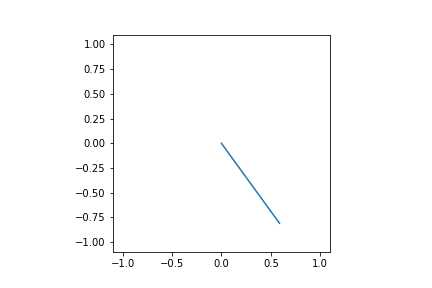
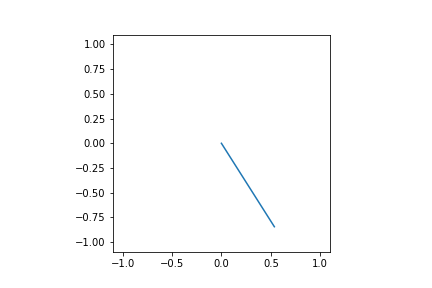
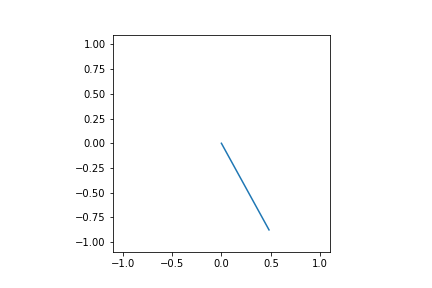
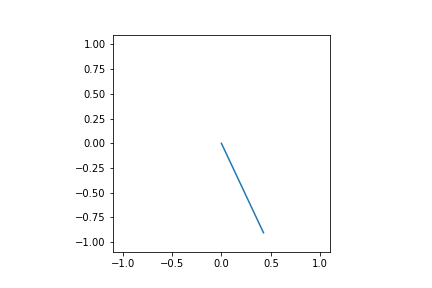
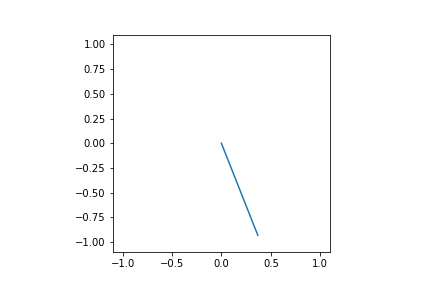
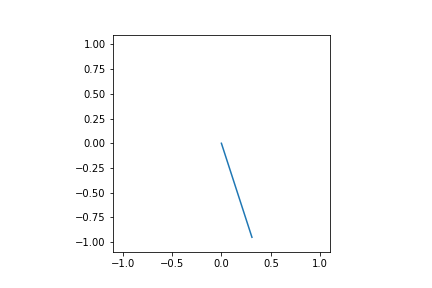
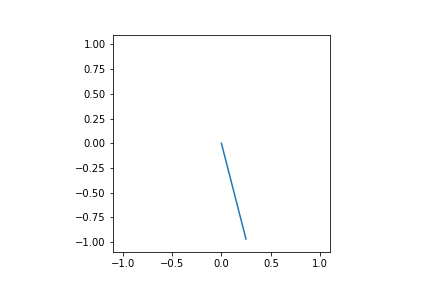
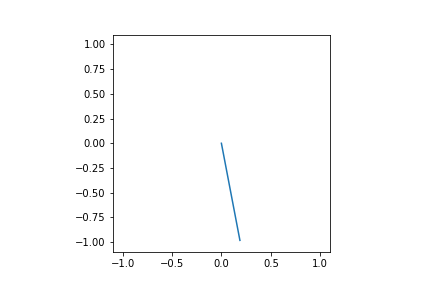
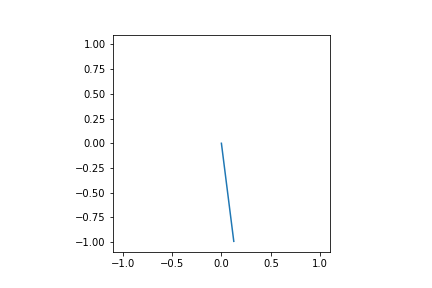
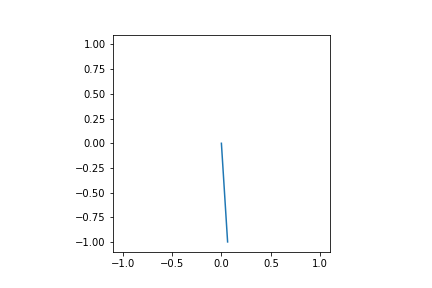
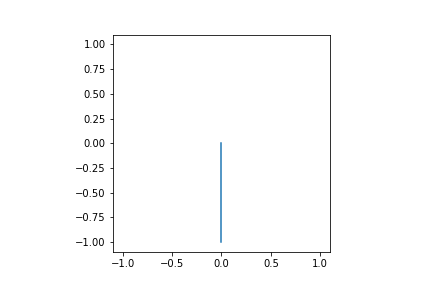
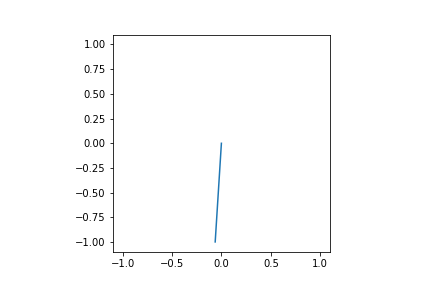
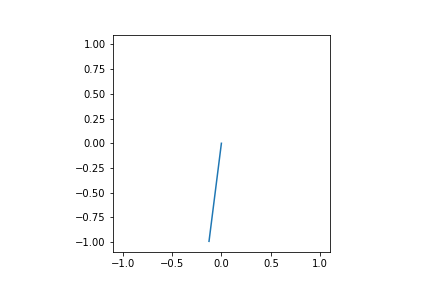
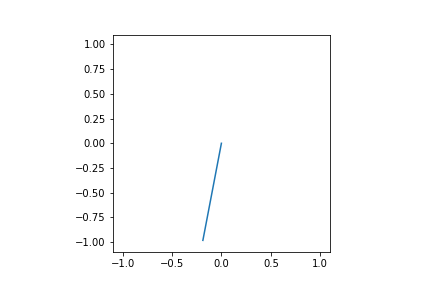
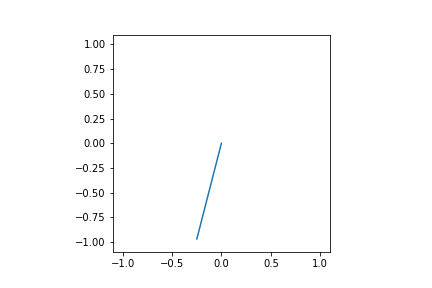
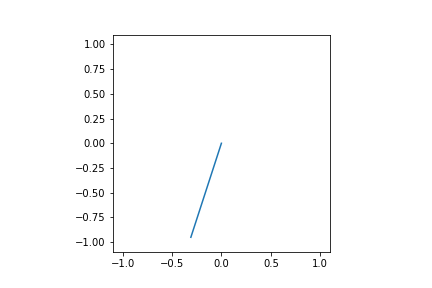
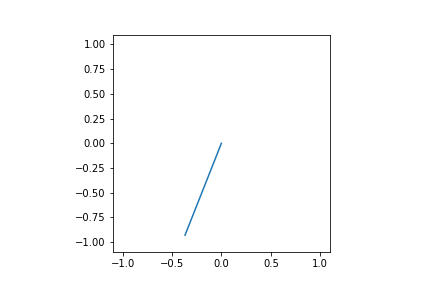
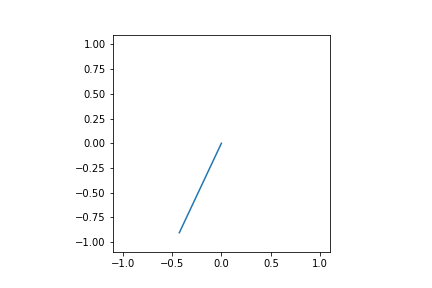
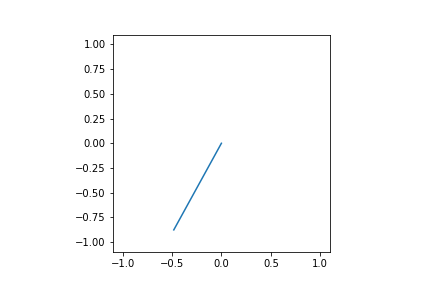
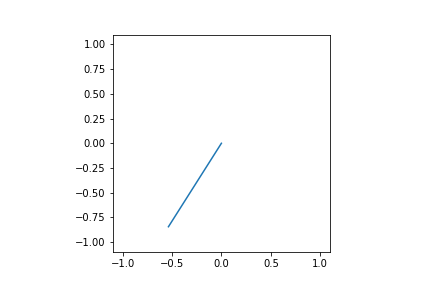
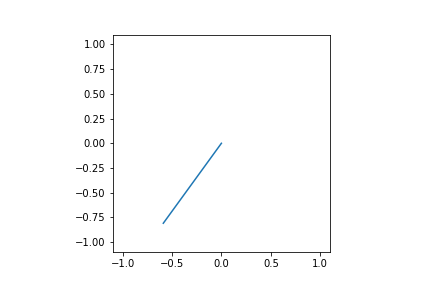
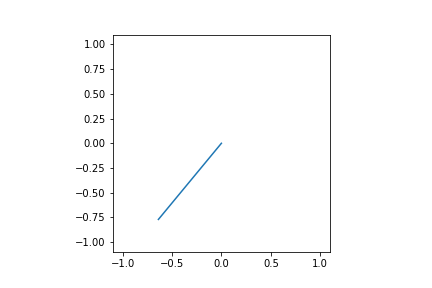
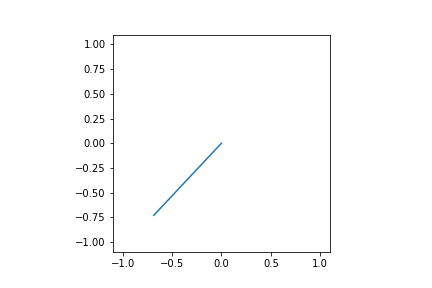
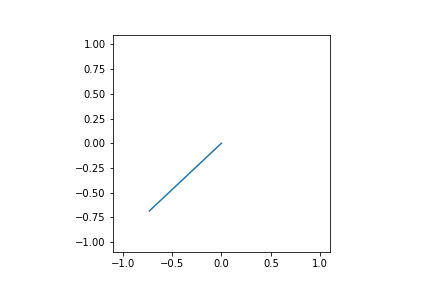
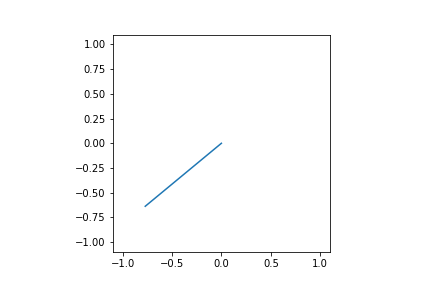
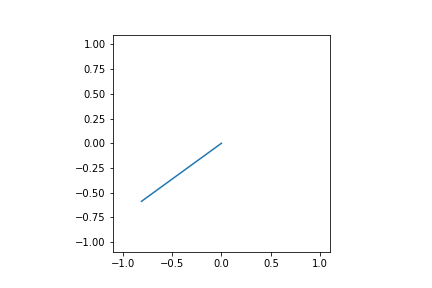
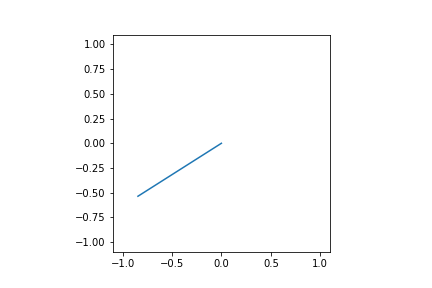
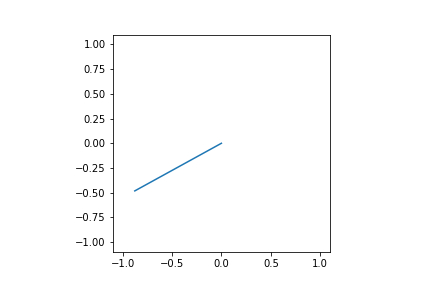
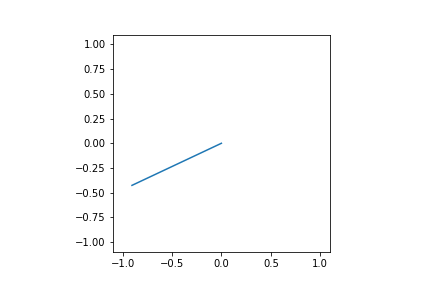
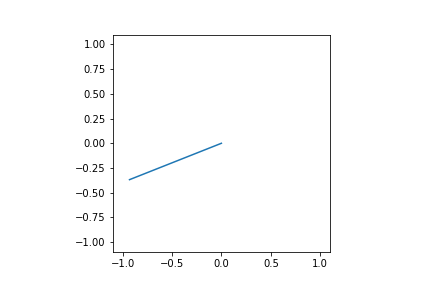
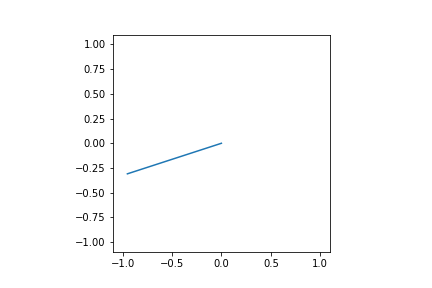
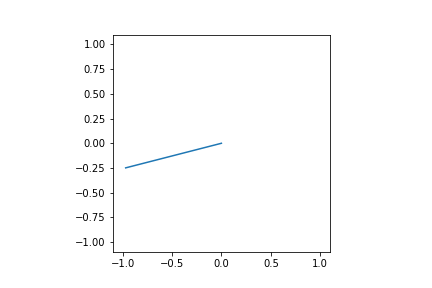
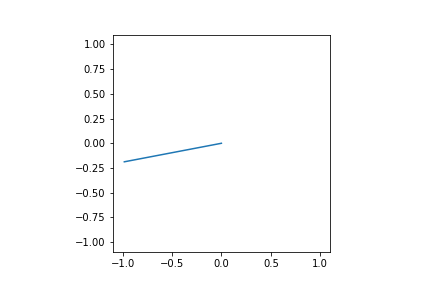
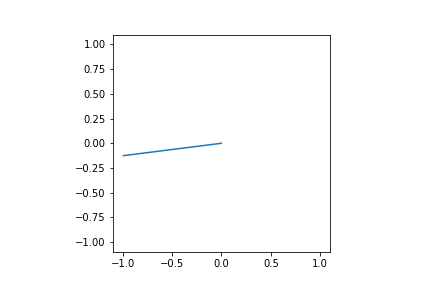
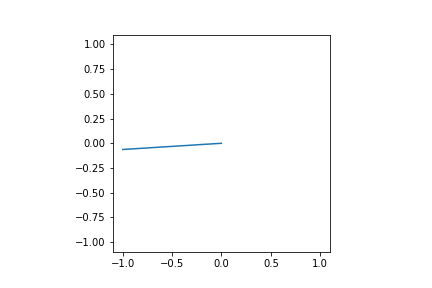
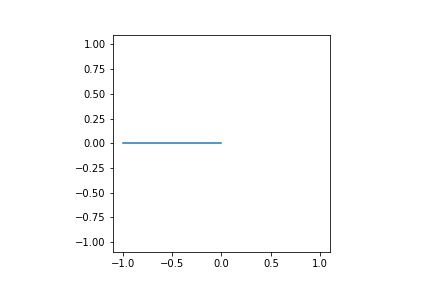
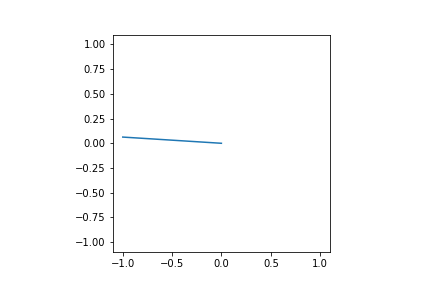
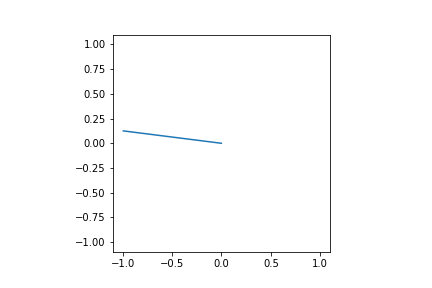
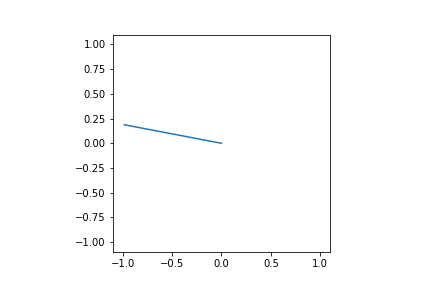
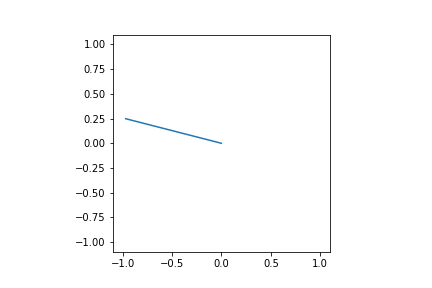
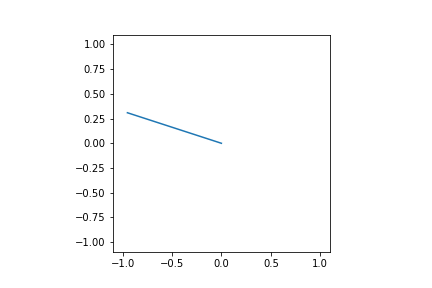
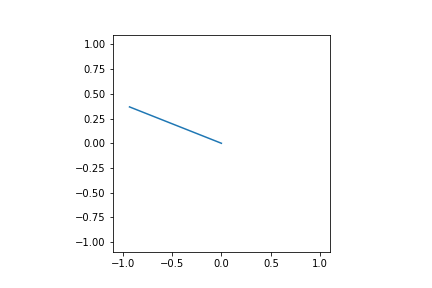
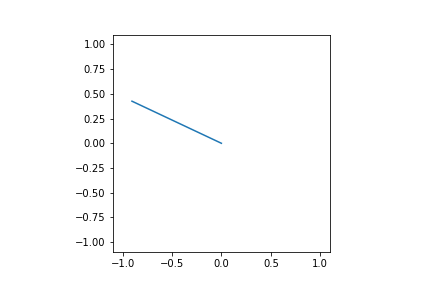
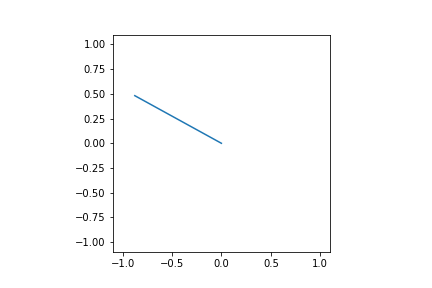
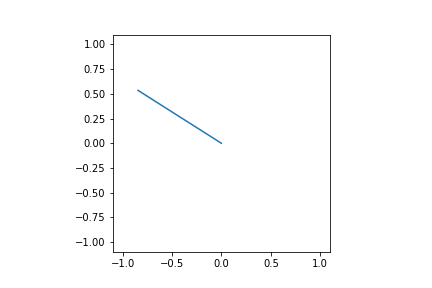
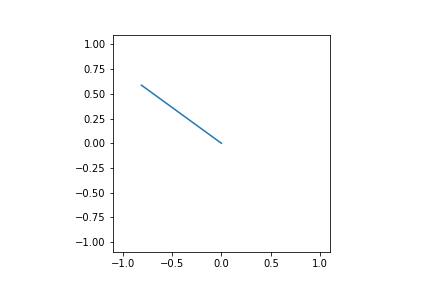
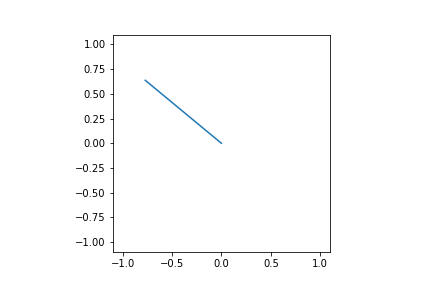
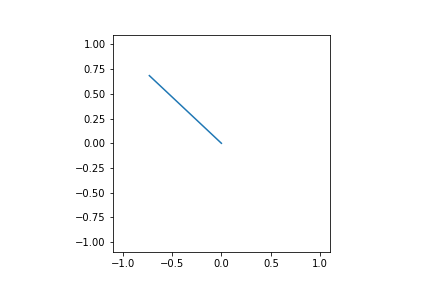
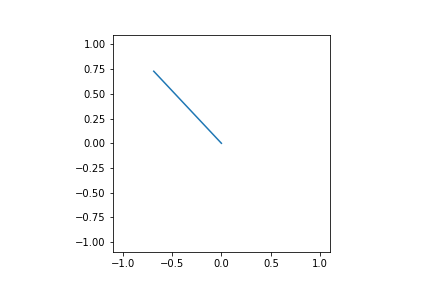
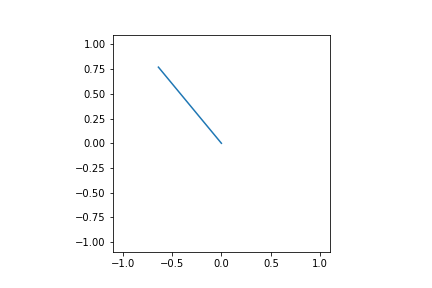
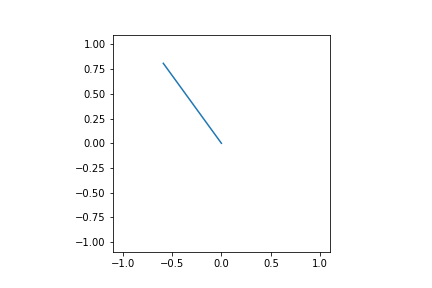
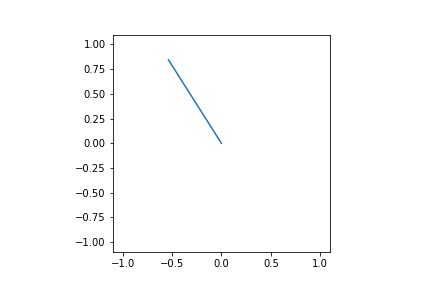
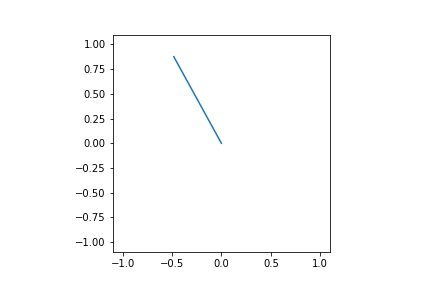
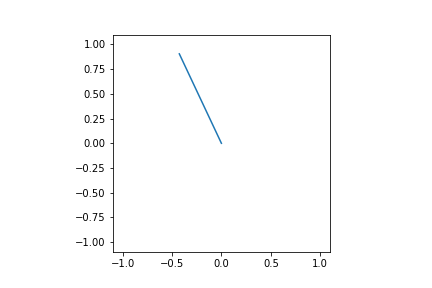
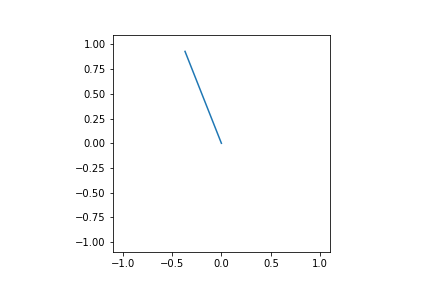
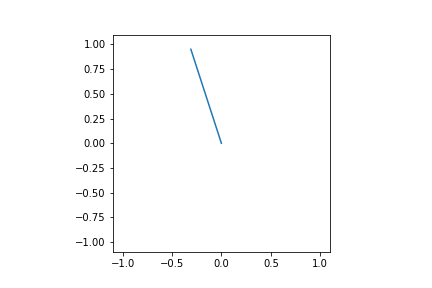
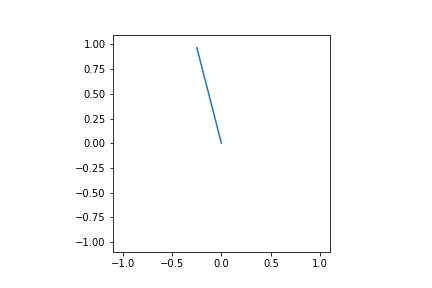
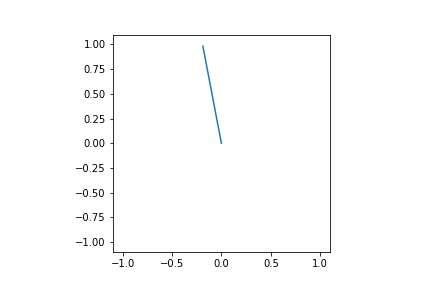
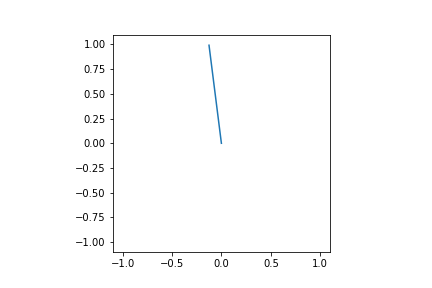
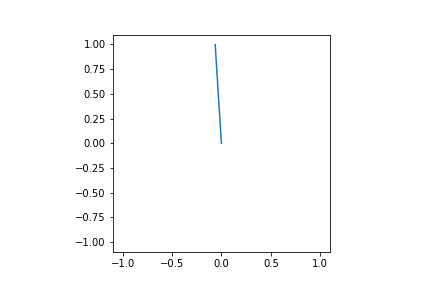
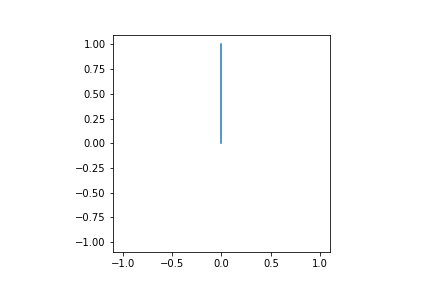
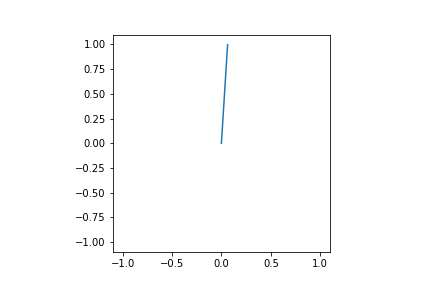
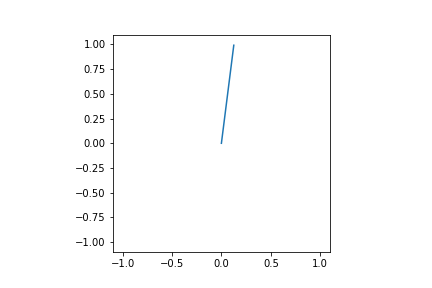
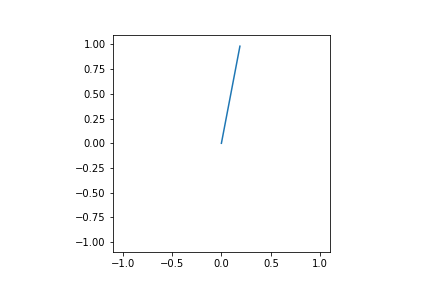
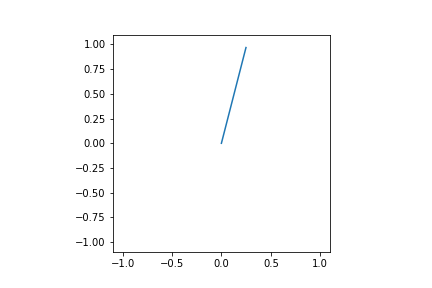
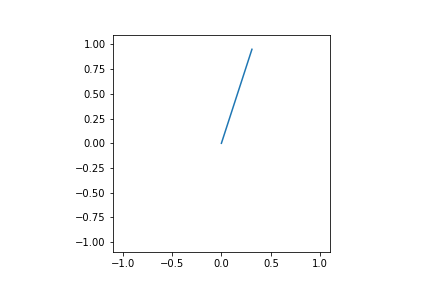
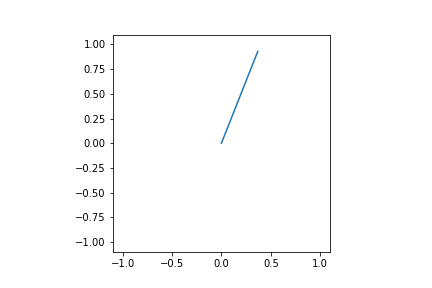
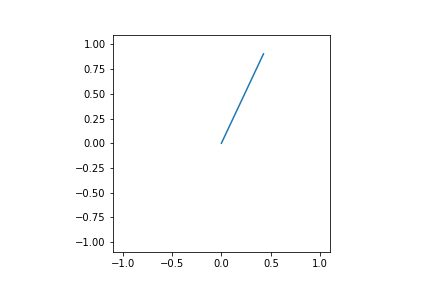
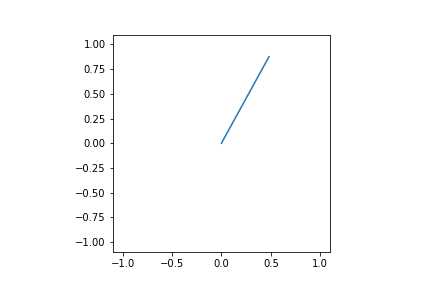
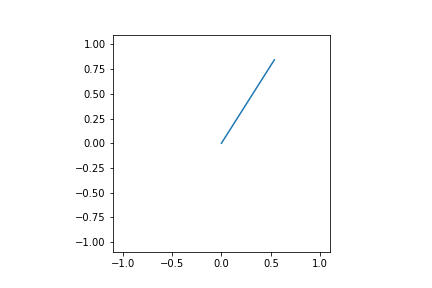
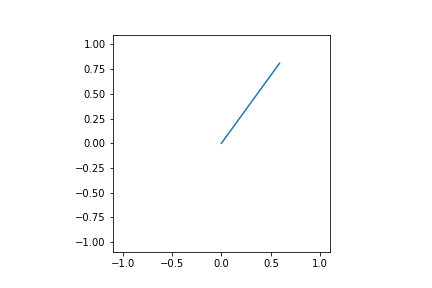
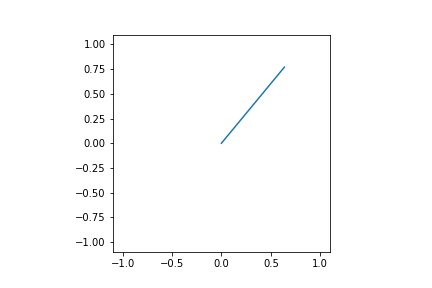
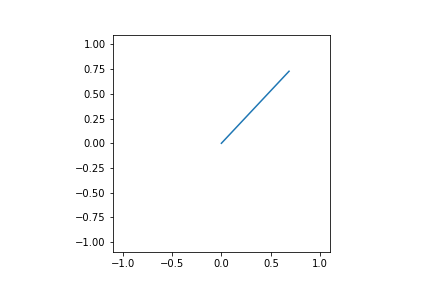
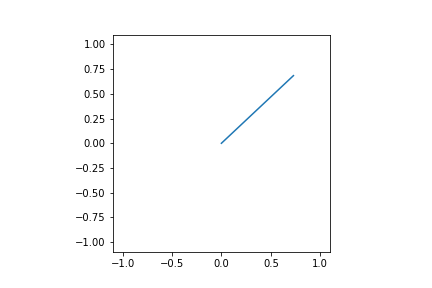
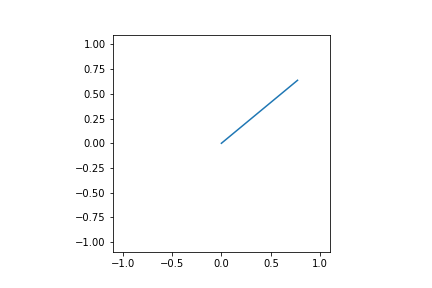
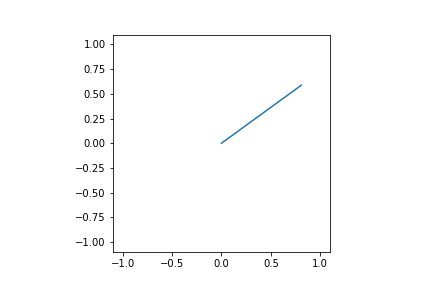
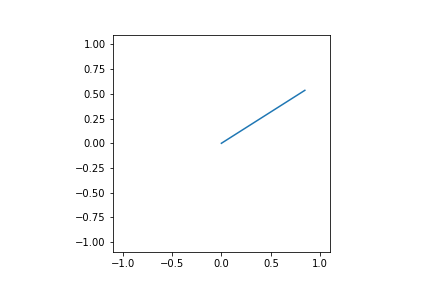
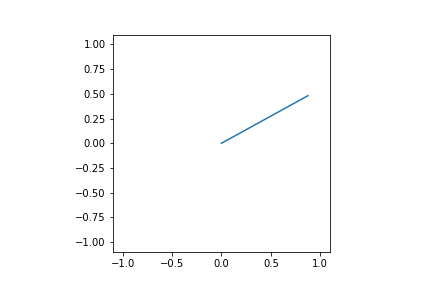
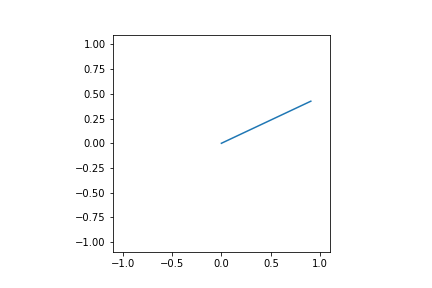
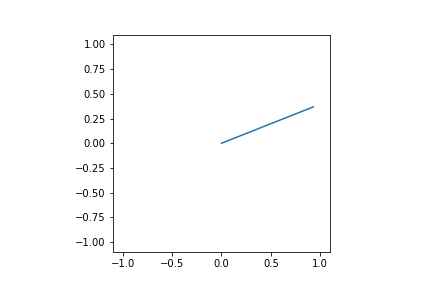
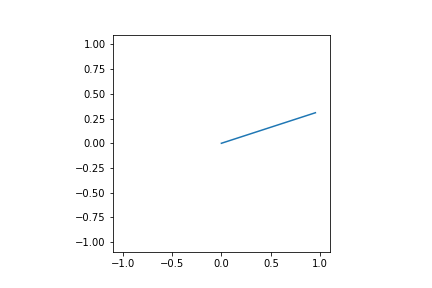
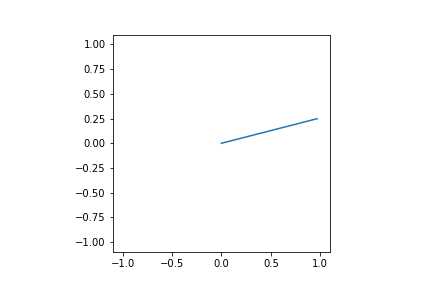
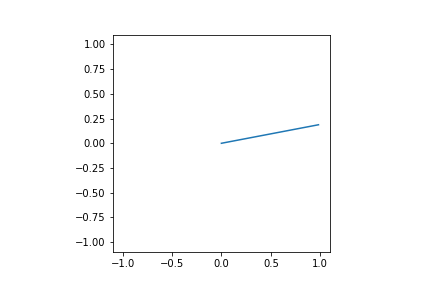
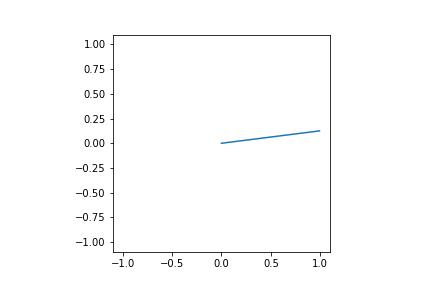
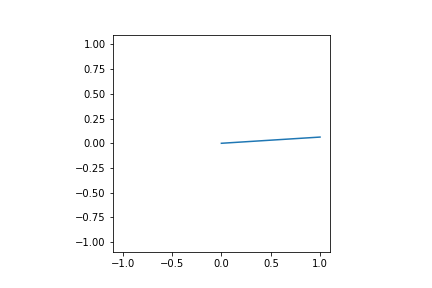

In [359]:
# How to make an animation

# Make a plot
fig,ax = plt.subplots(1)

# Add a line
line, = ax.plot([0,0],[0,1])
ax.set_xlim(-1.1,1.1)
ax.set_ylim(-1.1,1.1)
ax.set_aspect(1)

# define an animation function that changes the plot
def animate(f):
    theta = -2*np.pi*f / 100
    line.set_data([0,np.cos(theta)], [0,np.sin(theta)])

# build the animation
animation.FuncAnimation(fig, animate, frames=100, interval=20)


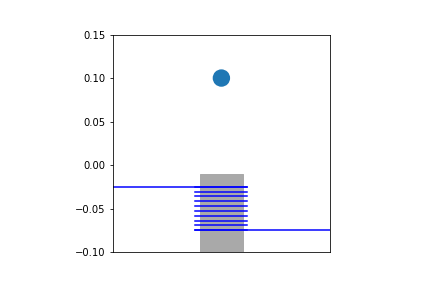
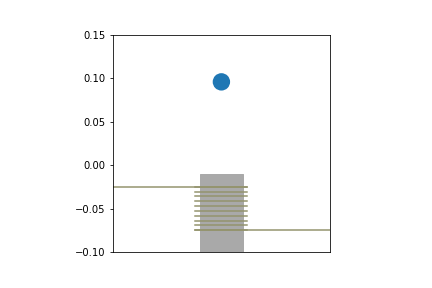
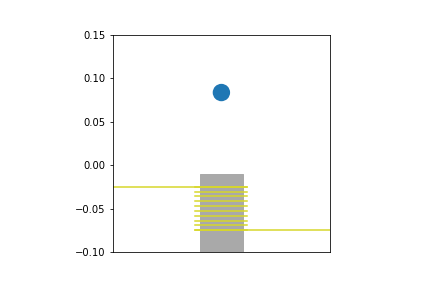
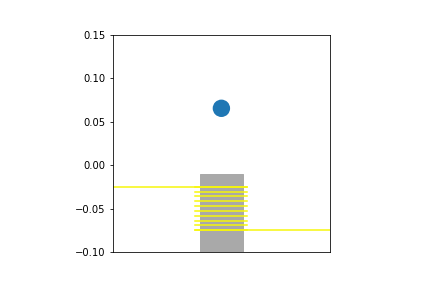
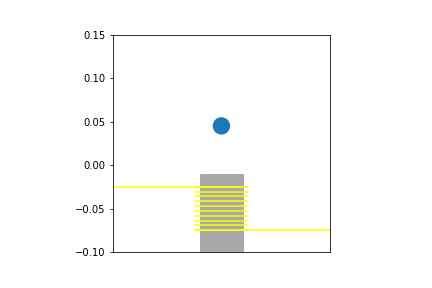
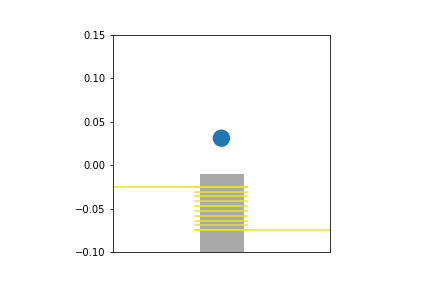
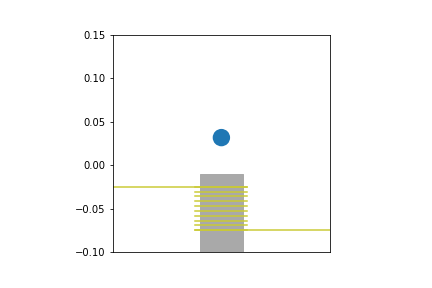
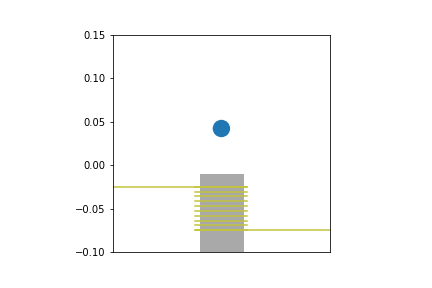
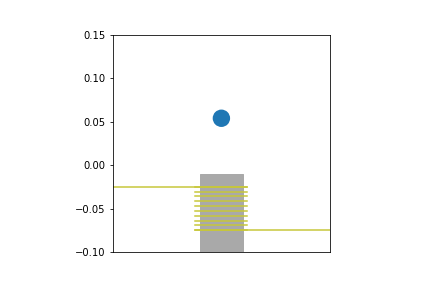
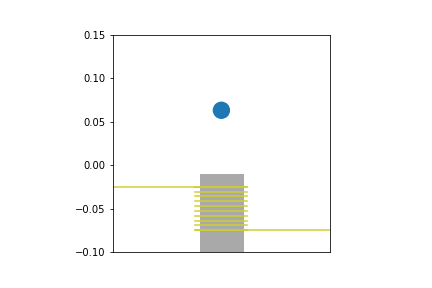
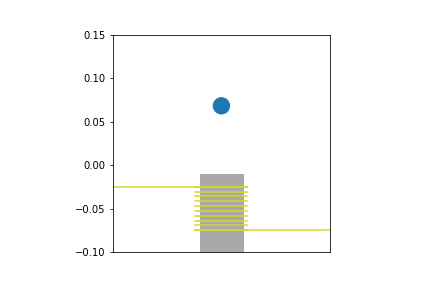
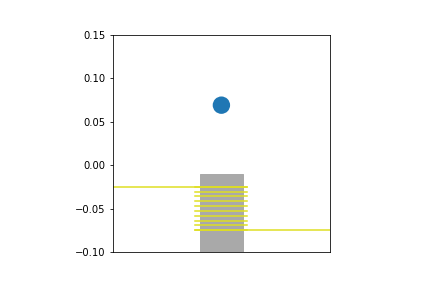
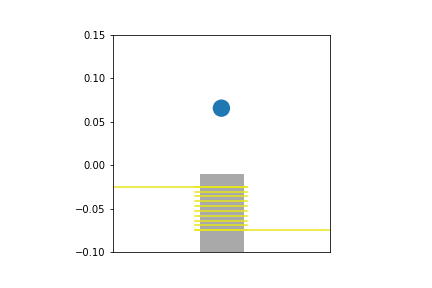
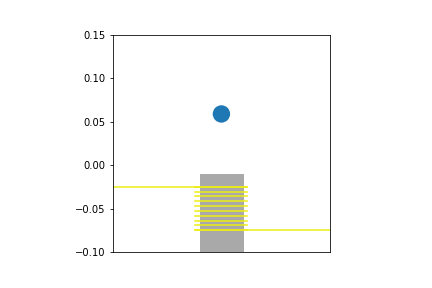
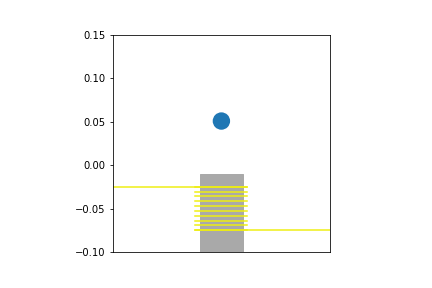
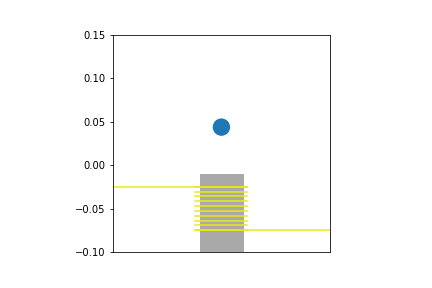
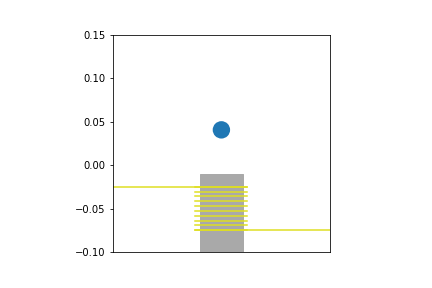
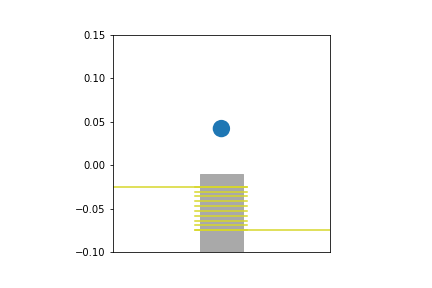
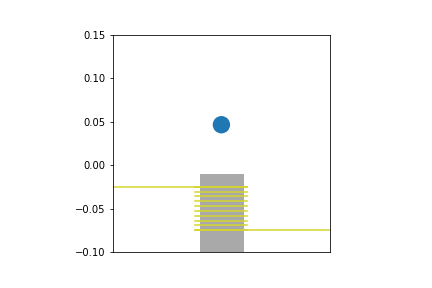
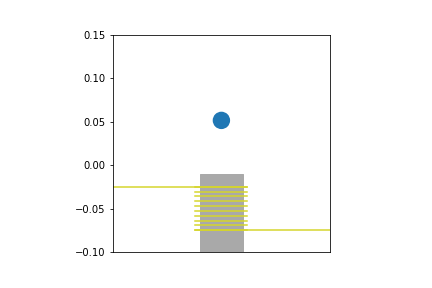
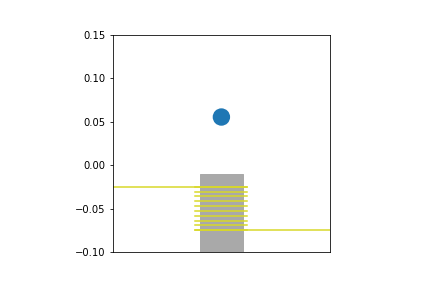
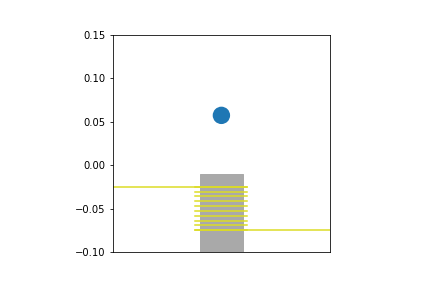
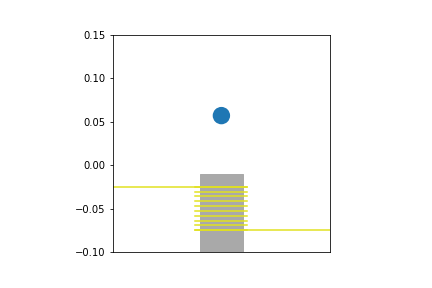
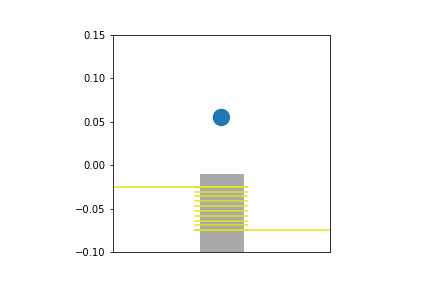
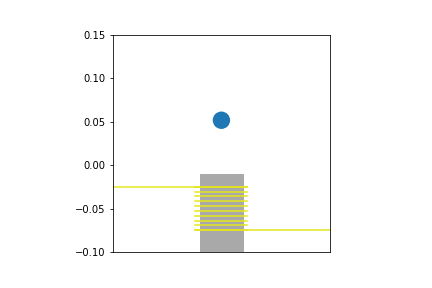
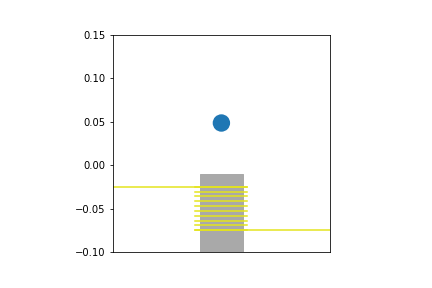
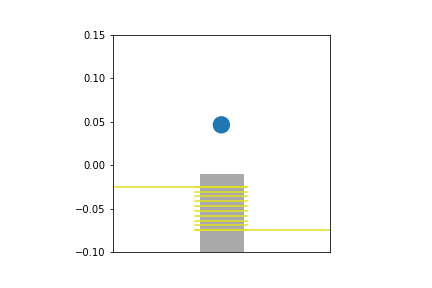
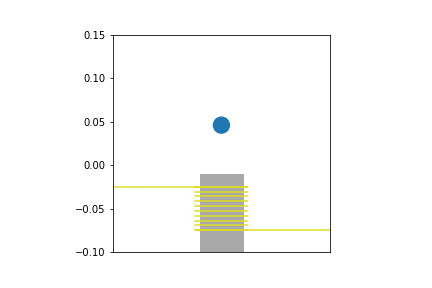
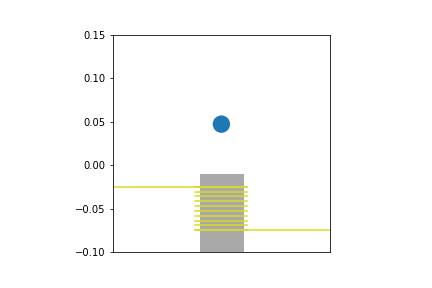
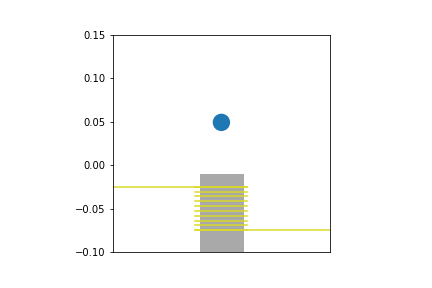
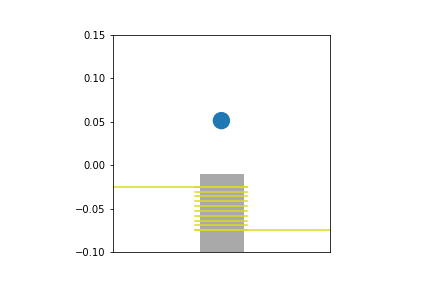
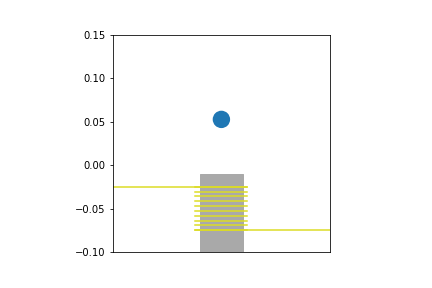
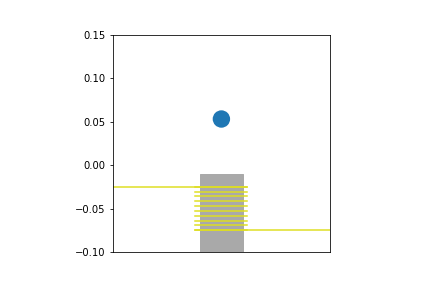
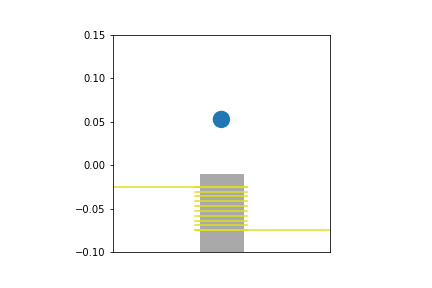
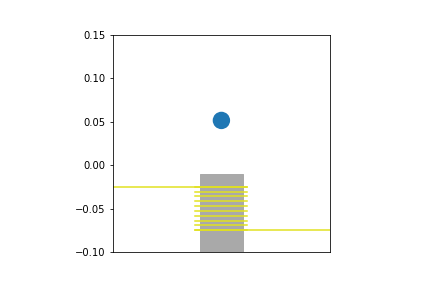
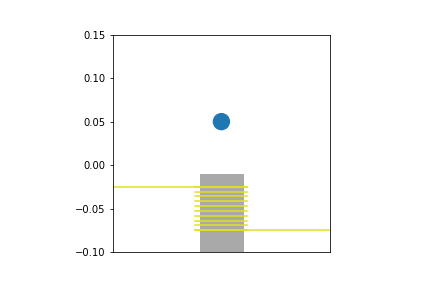
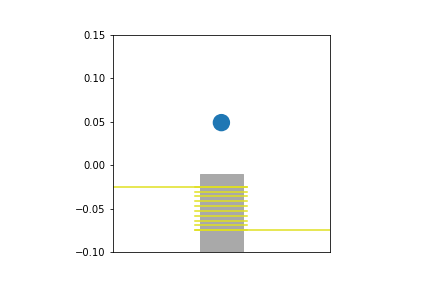
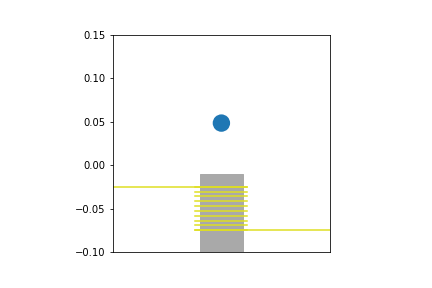
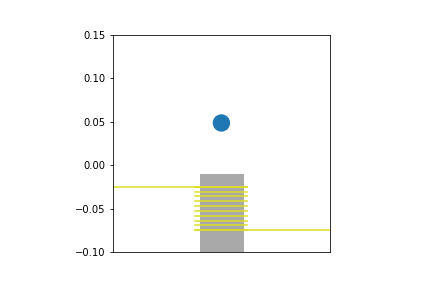
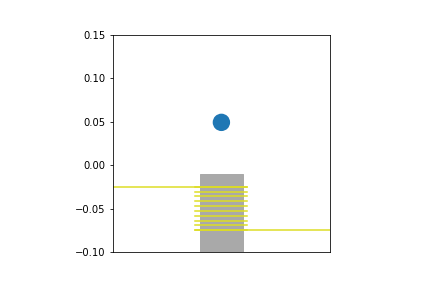
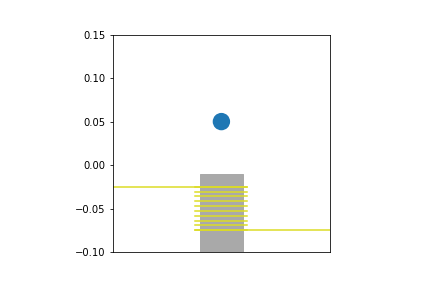
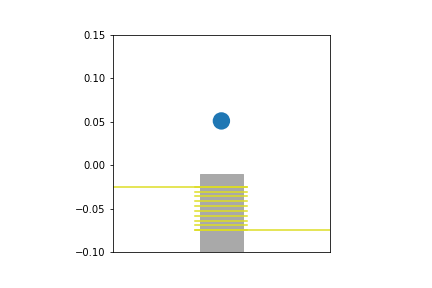
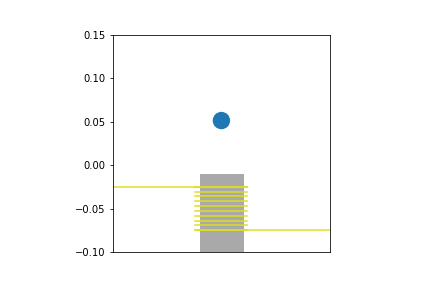
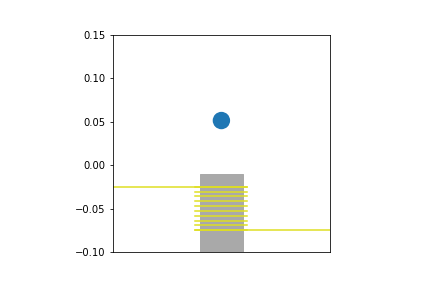
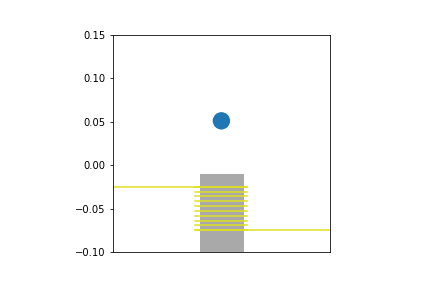
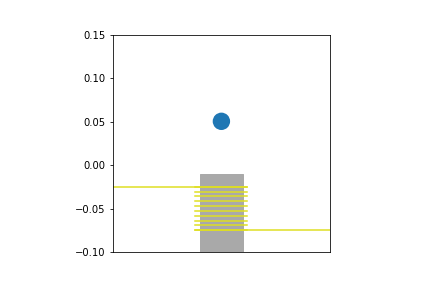
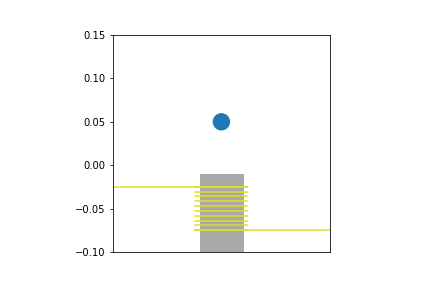
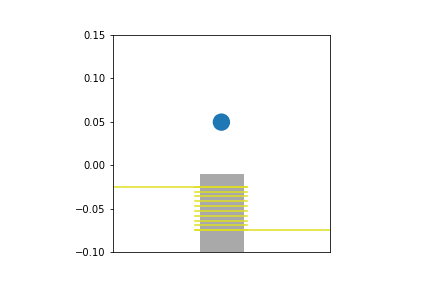
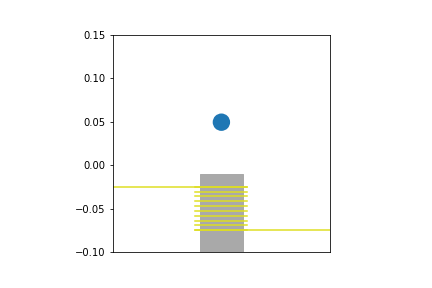
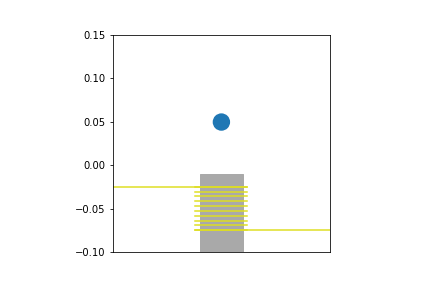
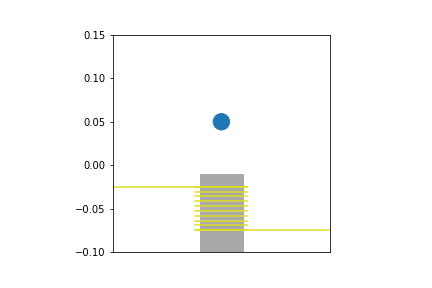
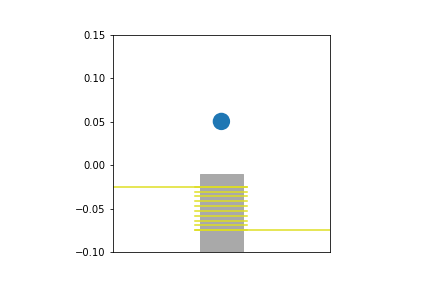
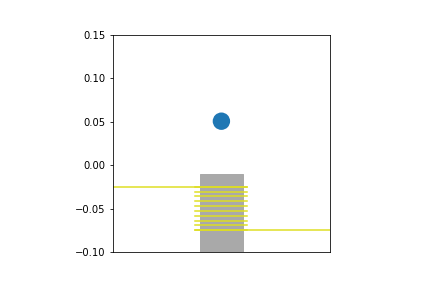
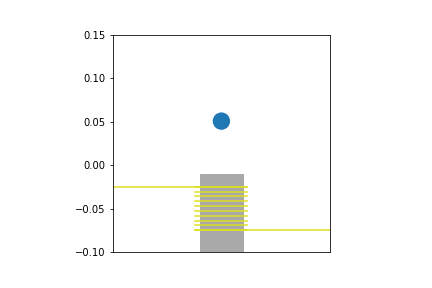
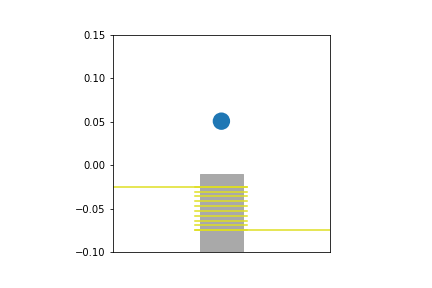
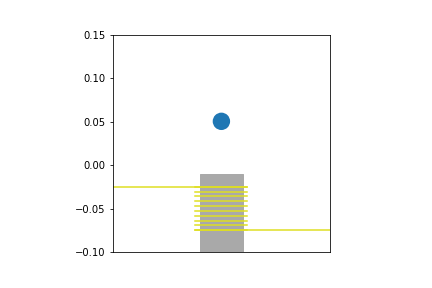
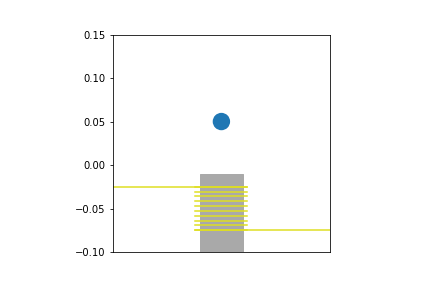
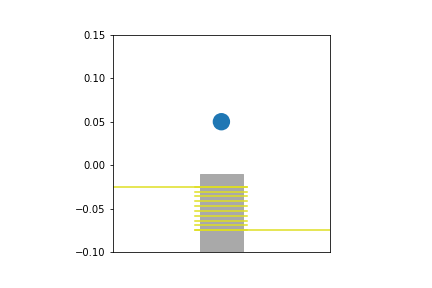
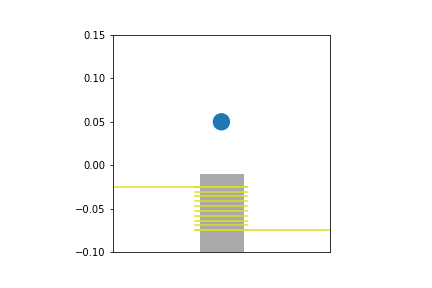
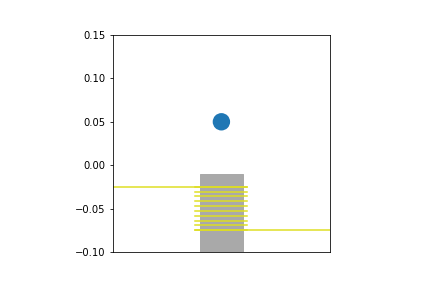
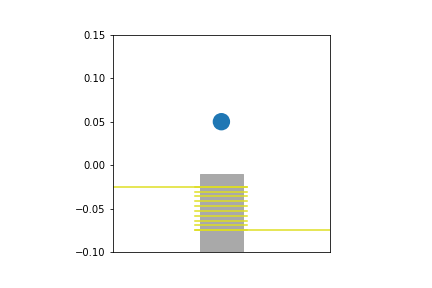
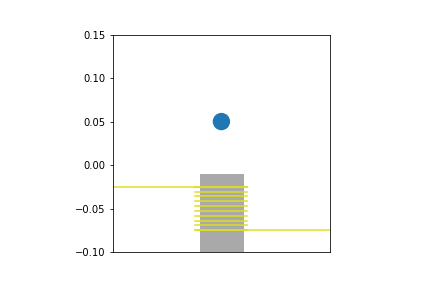
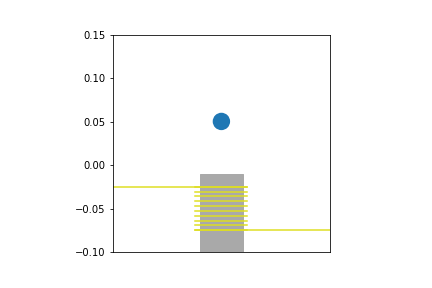
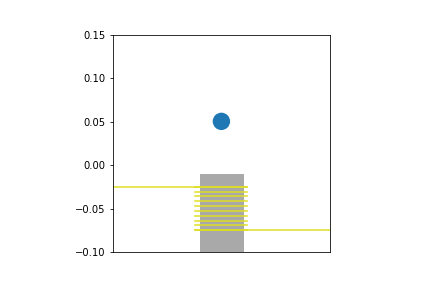
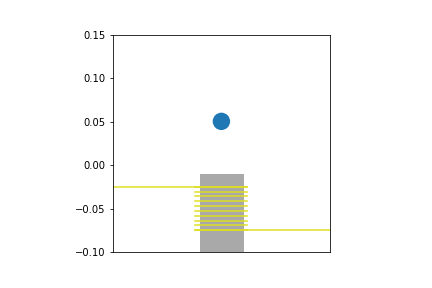
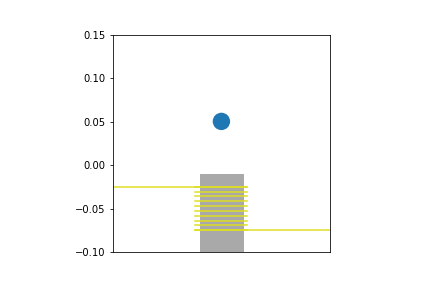
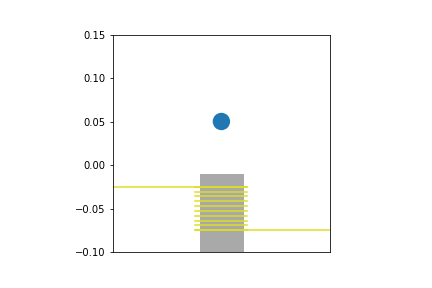
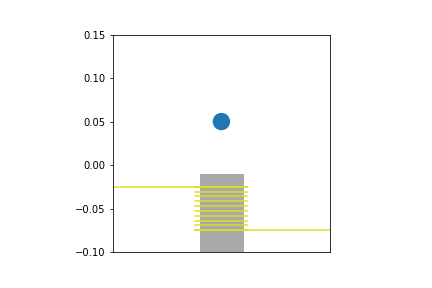
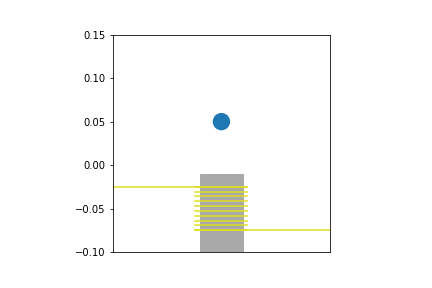
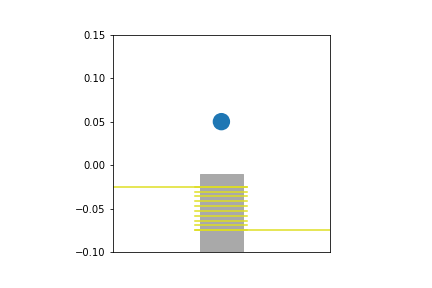
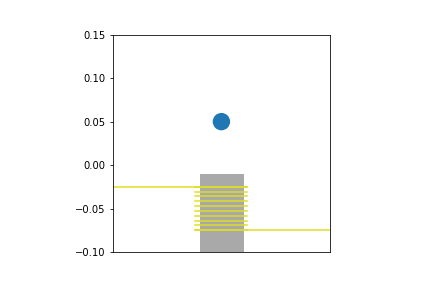
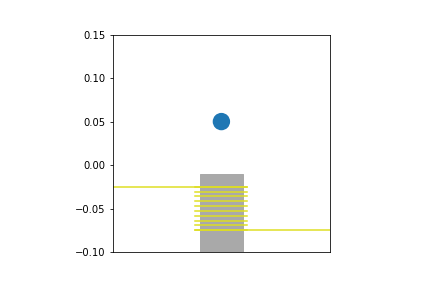
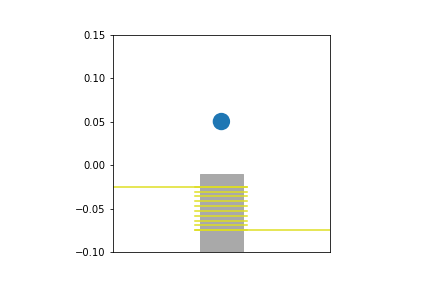
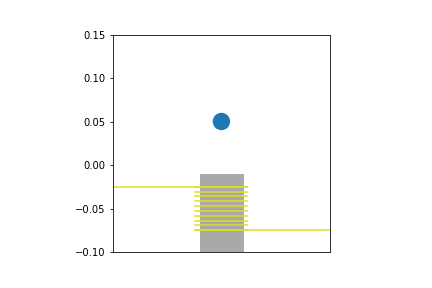
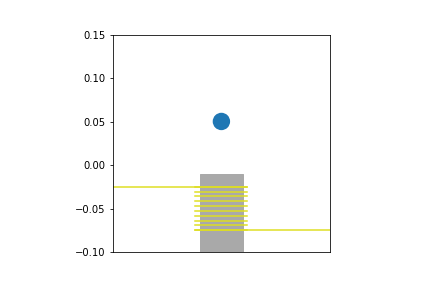
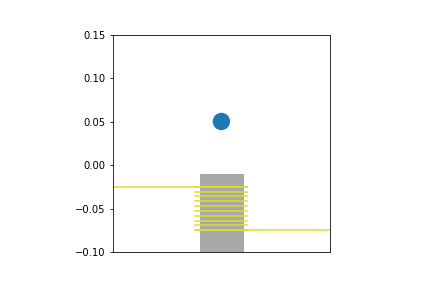
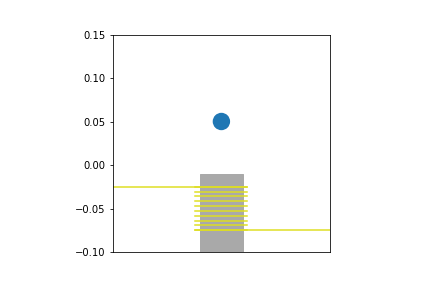
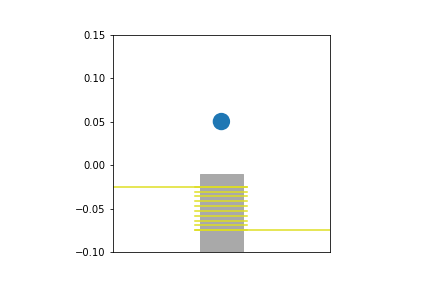
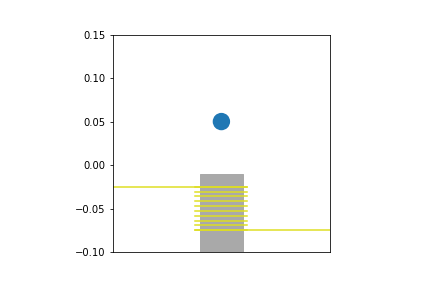
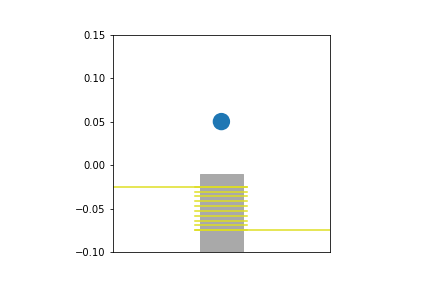
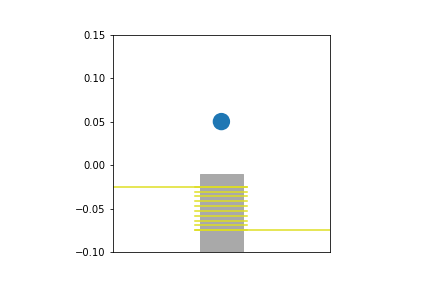
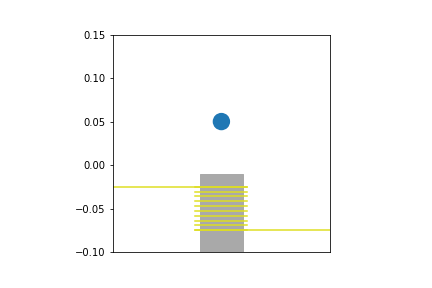
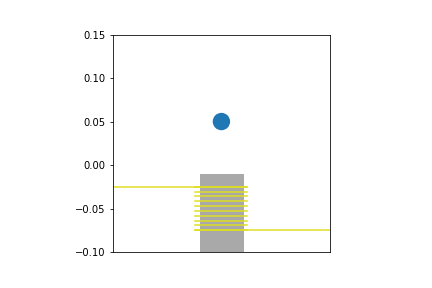
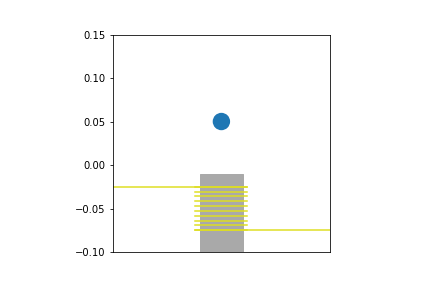
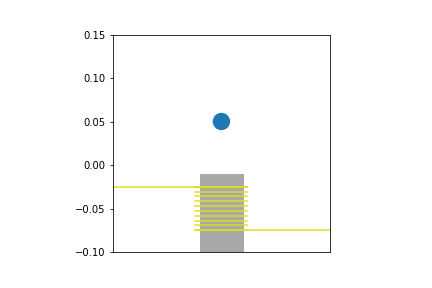
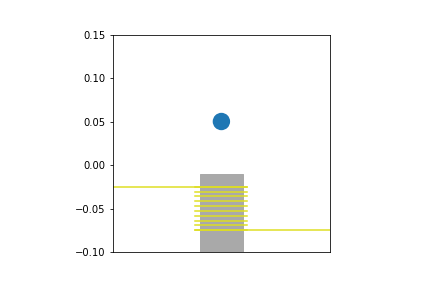
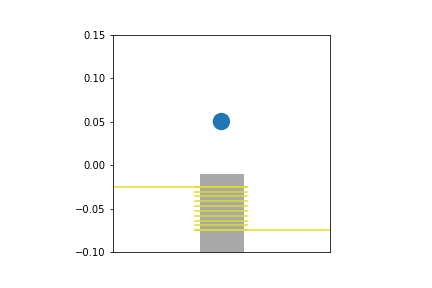
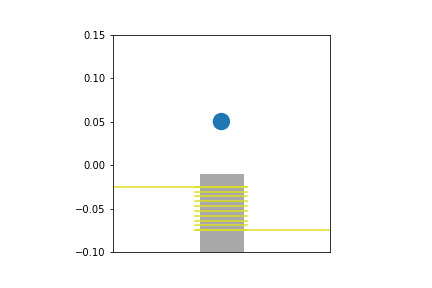
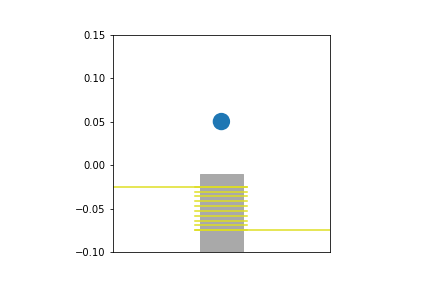
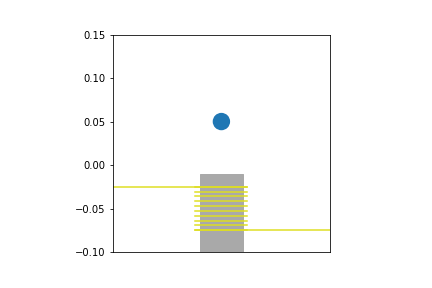
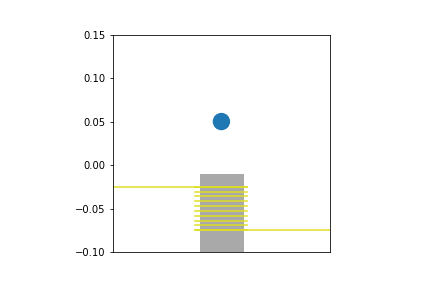
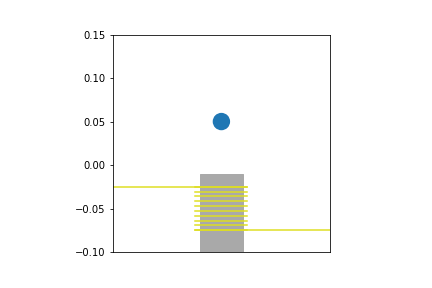
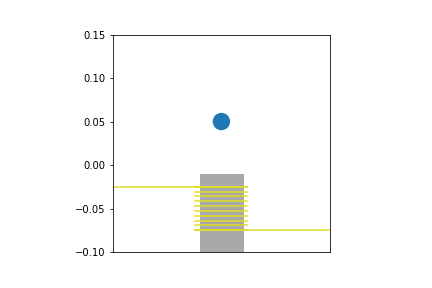
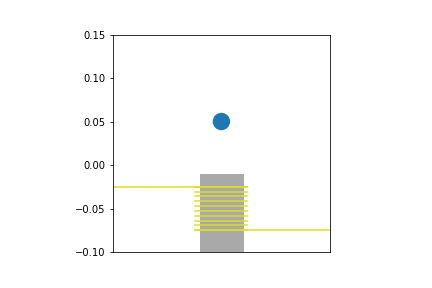
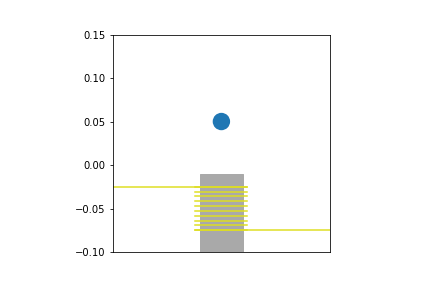
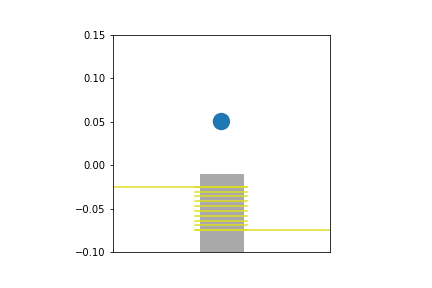
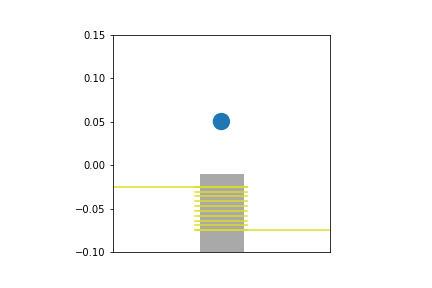
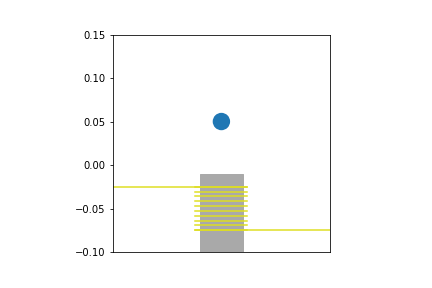
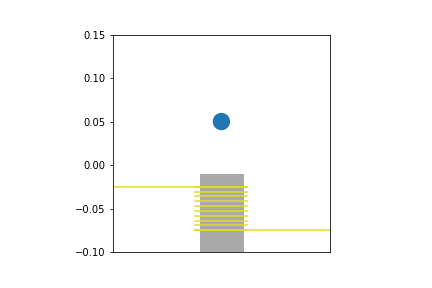
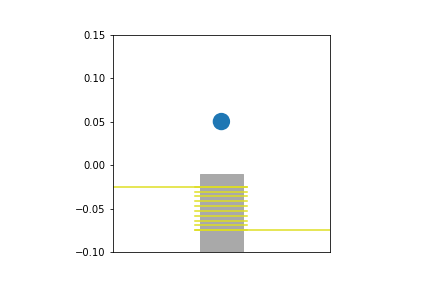

In [360]:
def anim():
    
    # This function is only here so that all the variables below are local to it and
    # we don't overwrite them as defined above.
    
    # Position and current
    x = X[:,0][0]
    i = X[:,2][0]
    
    # Max and min current, for colors
    cmax = max(X[:,2])
    cmin = min(X[:,2])

    # Make the plot
    fig,ax = plt.subplots(1)
    
    # Render the magnet core, ball, and coils
    mag = patches.Rectangle((-0.025,-0.1), 0.05, 0.1-0.01, color="darkgrey")
    ball = patches.Circle((1,x), 0.01)
    coils = ax.plot([-0.125,0.03], [-0.025, -0.025], [-0.03,0.125], [-0.075, -0.075], color='orange')
    for c in np.linspace(-0.025, -0.075,10):
        coils += ax.plot([-0.03,0.03], [c, c], color='orange')  

    # Add the parts to the plot
    ax.add_patch(ball)
    ax.add_patch(mag)
    
    # Make it look nice
    ax.set_xlim(-.125,.125)
    ax.set_ylim(-.1,.15)
    ax.set_xticks([])
    ax.set_aspect(1)

    # Make a frame for each element of the simulation output X
    num_frames = len(X)

    # Define a function that will be called for each frame. It modifies the 
    # position of the ball and the color of the coil.
    def animate(f):
        x = X[:,0][f]
        ball.set_center((0,x))
        c = ( X[:,2][f] - cmin ) / ( cmax - cmin )
        for coil in coils:
            coil.set_color((c,c,1-c))

    # Build the animation
    anim = animation.FuncAnimation(fig, animate, frames=num_frames, interval=20)
    return display_animation(anim, default_mode='loop')
    
anim()